# Libraries

In [8]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [11]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [4]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [5]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean/selection'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [6]:
# Load amino acid info
aa_info_dicts = load_aa_info(aa_info_file )

In [6]:
# def process_pdb_directory(directory, aa_info_dict, neighborhood_radius=10.0):
#     """Process all PDB files in a directory and return a list of DataFrames."""
#     pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
#     dataframes = []

#     for pdb_file in tqdm(pdb_files, desc="Processing PDBs"):
#         analyzer = ProteinAnalyzer4(pdb_file, aa_info_dict, neighborhood_radius)
#         df = analyzer.create_combined_dataframe()
#         dataframes.append((pdb_file, df))

#     return dataframes

In [7]:
# # Process directory of PDB files
# dataframes = process_pdb_directory(pdb_directory, aa_info_dicts, neighborhood_radius=10.0)


In [13]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info_dict = aa_info.set_index('Short').to_dict(orient='index')

# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


In [18]:
results[7]

('data/all_nano_structures_single_domain_clean/selection/5o04.pdb',
               X          Y       Z  Avg_Mass  Avg_Neighbor_Dist  \
 0    -10.625000 -28.360001  12.861         0           3.810475   
 1    -14.221000 -27.716999  13.945         0           3.806736   
 2    -16.791000 -30.054001  12.397         0           3.799121   
 3    -20.525999 -30.719000  12.290         0           3.800214   
 4    -22.320000 -33.959999  11.420         0           3.803667   
 ...         ...        ...     ...       ...                ...   
 1071 -19.396000  22.650000   6.169         0           3.799353   
 1072 -20.305000  25.843000   4.321         0           3.800602   
 1073 -17.778999  27.958000   6.218         0           3.804394   
 1074 -14.463000  26.385000   5.206         0           3.806774   
 1075 -12.166000  26.846001   2.206         0           3.806406   
 
       Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0              3.810475               1        

# Attempt increase speed

## Partial

In [8]:
# import multiprocessing
# from functools import partial

# # Load amino acid info
# aa_info_dicts = load_aa_info(aa_info_file )

# def process_single_pdb(pdb_file, aa_info_dicts, neighborhood_radius):
#     """Process a single PDB file."""
#     analyzer = ProteinAnalyzer4(pdb_file, aa_info_dicts, neighborhood_radius)
#     return pdb_file, analyzer.create_combined_dataframe()

# def parallel_process_pdbs(pdb_files, aa_info_dicts, neighborhood_radius=10.0, n_jobs=None):
#     """Parallelize the processing of PDB files."""
#     n_jobs = n_jobs or multiprocessing.cpu_count()
#     with multiprocessing.Pool(n_jobs) as pool:
#         results = pool.map(partial(process_single_pdb, aa_info_dicts=aa_info_dicts, neighborhood_radius=neighborhood_radius), pdb_files)
#     return results

# # Run parallel processing
# from tqdm import tqdm
# pdb_files = [os.path.join(pdb_directory, f) for f in os.listdir(pdb_directory) if f.endswith('.pdb')]
# dataframes = parallel_process_pdbs(pdb_files, aa_info_dicts, neighborhood_radius=10.0)


## Joblib

In [19]:
# from joblib import Parallel, delayed

# def process_single_pdb(pdb_file):
#     analyzer = ProteinAnalyzer4(pdb_file, aa_info_dicts, neighborhood_radius=10.0)
#     return pdb_file, analyzer.create_combined_dataframe()

# # Parallel processing with joblib
# pdb_files = [os.path.join(pdb_directory, f) for f in os.listdir(pdb_directory) if f.endswith('.pdb')]
# dataframes = Parallel(n_jobs=3)(delayed(process_single_pdb)(pdb_file) for pdb_file in tqdm(pdb_files))


In [7]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [11]:
def convert_df_to_graph(df, distance_threshold=5.0):
    """Convert a DataFrame to a graph representation."""
    import torch
    from torch_geometric.data import Data

    coords = df[['X', 'Y', 'Z']].values
    edge_index = []
    edge_attr = []

    # Build edges based on distance threshold
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= distance_threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])  # Bidirectional edges
                edge_attr.append([dist])
                edge_attr.append([dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    # Node features
    node_features = torch.tensor(df.drop(columns=['X', 'Y', 'Z']).values, dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)


In [12]:
graphs = [(pdb, convert_df_to_graph(df)) for pdb, df in dataframes]

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [4]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
       X      Y      Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  I  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  I  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  E  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  K  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  L  131.17464           3.853064           3.855114   

   Neighbor_Count  
0             1.0  
1             2.0  
2             2.0  
3             2.0  
4             2.0  


In [5]:

from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

       X      Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  131.17464           3.853064           3.855114   

   Neighbor_Count  AA_A  AA_C  AA_D  ...  AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  \
0             1.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   AA_T  AA_V  AA_W  AA_Y  
0   0.0   0.0   0.0   0.0  
1   0.0   0.

In [6]:
def create_graphs_from_df_array(df_array):
    """Convert array of DataFrames to list of PyG Data objects using actual neighbor counts"""
    graphs = []
    errors = []

    for idx, df in enumerate(tqdm(df_array, desc="Creating graphs")):
        try:
            # Verify neighbor counts
            neighbor_counts = df['Neighbor_Count'].values
            if (neighbor_counts <= 0).any():
                raise ValueError(f"Found invalid neighbor count in graph {idx}: "
                                 f"min count = {neighbor_counts.min()}")

            # Extract coordinates and create distance matrix
            coords = df[['X', 'Y', 'Z']].values
            distances = torch.cdist(torch.tensor(coords), torch.tensor(coords))

            # Initialize lists for source and target nodes
            sources = []
            targets = []

            # Create edges based on actual neighbor counts
            for node_idx, n_count in enumerate(neighbor_counts):
                # Get n_count nearest neighbors for this node
                n_count = int(n_count)
                _, neighbors = distances[node_idx].topk(n_count + 1, largest=False)
                # Remove self-loop
                neighbors = neighbors[1:n_count + 1]

                # Verify we got enough neighbors
                if len(neighbors) != n_count:
                    raise ValueError(f"Could not find {n_count} neighbors for node {node_idx}")

                # Add edges in both directions for undirected graph
                sources.extend([node_idx] * len(neighbors))
                targets.extend(neighbors.tolist())
                # Add reverse edges
                sources.extend(neighbors.tolist())
                targets.extend([node_idx] * len(neighbors))

            # Create edge_index tensor
            edge_index = torch.tensor([sources, targets], dtype=torch.long)

            # Create node features
            feature_cols = [col for col in df.columns if col.startswith('AA_')]
            features = df[feature_cols].values
            other_features = df[['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist']].values
            node_features = np.concatenate([features, other_features], axis=1)

            # Create position tensor
            pos = torch.tensor(coords, dtype=torch.float)

            # Create graph
            graph = Data(
                x=torch.tensor(node_features, dtype=torch.float),
                edge_index=edge_index,
                pos=pos,
                neighbor_count=torch.tensor(neighbor_counts, dtype=torch.float)
            )

            # Verify neighbor counts match
            for node_idx, expected_count in enumerate(neighbor_counts):
                actual_count = (edge_index[0] == node_idx).sum().item()
                if abs(actual_count - expected_count * 2) > 0.5:  # Multiply by 2 because we added reverse edges
                    raise ValueError(f"Mismatch in neighbor count for node {node_idx}: "
                                     f"expected {expected_count*2}, got {actual_count}")

            graphs.append(graph)

        except Exception as e:
            errors.append({
                'graph_idx': idx,
                'error': str(e),
                'neighbor_counts': neighbor_counts
            })
            logger.error(f"Error processing graph {idx}: {str(e)}")

    if errors:
        logger.error(f"Encountered {len(errors)} errors while creating graphs:")
        for error in errors:
            logger.error(f"Graph {error['graph_idx']}: {error['error']}")
            logger.error(f"Neighbor counts: {error['neighbor_counts']}")

    if not graphs:
        raise ValueError("No valid graphs were created!")

    # Print statistics about the created graphs
    logger.info(f"Successfully created {len(graphs)} graphs out of {len(df_array)} input structures")
    avg_nodes = np.mean([g.num_nodes for g in graphs])
    avg_edges = np.mean([g.num_edges for g in graphs])
    avg_neighbors = np.mean([g.neighbor_count.mean().item() for g in graphs])
    logger.info(f"Average nodes per graph: {avg_nodes:.2f}")
    logger.info(f"Average edges per graph: {avg_edges:.2f}")
    logger.info(f"Average neighbors per node: {avg_neighbors:.2f}")

    # Detailed neighbor count analysis
    all_neighbor_counts = np.concatenate([g.neighbor_count.numpy() for g in graphs])
    logger.info("\nNeighbor count statistics:")
    logger.info(f"Min neighbors: {all_neighbor_counts.min():.0f}")
    logger.info(f"Max neighbors: {all_neighbor_counts.max():.0f}")
    logger.info(f"Mean neighbors: {all_neighbor_counts.mean():.2f}")
    logger.info(f"Median neighbors: {np.median(all_neighbor_counts):.0f}")

    # Plot neighbor count distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_neighbor_counts, bins=30)
    plt.title('Distribution of Neighbor Counts')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Frequency')
    plt.show()

    return graphs

def validate_protein_graph(graph):
    """Validate that a graph represents a valid protein structure"""
    issues = []

    # Check that all nodes have neighbors
    for node_idx in range(graph.num_nodes):
        neighbors = (graph.edge_index[0] == node_idx).nonzero().squeeze()
        if len(neighbors) == 0:
            issues.append(f"Node {node_idx} has no neighbors")

        expected_count = graph.neighbor_count[node_idx].item()
        actual_count = len(neighbors) // 2  # Divide by 2 because graph is undirected
        if abs(actual_count - expected_count) > 0.5:
            issues.append(f"Node {node_idx} has {actual_count} neighbors but expected {expected_count}")

    # Check edge index consistency
    if graph.edge_index.size(1) % 2 != 0:
        issues.append("Edge index is not symmetric (odd number of edges)")

    # Check for self-loops
    self_loops = (graph.edge_index[0] == graph.edge_index[1]).sum().item()
    if self_loops > 0:
        issues.append(f"Found {self_loops} self-loops")

    return issues

def visualize_protein_graph(graph, index=0):
    """Visualize a protein graph structure with detailed analysis"""
    import networkx as nx

    # Convert to networkx graph
    G = nx.Graph()

    # Add nodes with neighbor count attribute
    for i in range(graph.num_nodes):
        G.add_node(i, neighbor_count=graph.neighbor_count[i].item())

    # Add edges
    edge_list = graph.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Create subplot layout
    fig = plt.figure(figsize=(20, 6))

    # 3D structure plot
    ax1 = fig.add_subplot(131, projection='3d')
    pos = graph.pos.numpy()
    ax1.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=graph.neighbor_count, cmap='viridis', s=100)

    for edge in G.edges():
        x = [pos[edge[0], 0], pos[edge[1], 0]]
        y = [pos[edge[0], 1], pos[edge[1], 1]]
        z = [pos[edge[0], 2], pos[edge[1], 2]]
        ax1.plot(x, y, z, 'gray', alpha=0.3)

    ax1.set_title('3D Structure')

    # Node degree distribution
    ax2 = fig.add_subplot(132)
    degrees = [G.degree(n) for n in G.nodes()]
    ax2.hist(degrees, bins=20)
    ax2.set_title('Node Degree Distribution')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Count')

    # Neighbor count distribution
    ax3 = fig.add_subplot(133)
    neighbor_counts = graph.neighbor_count.numpy()
    ax3.hist(neighbor_counts, bins=20)
    ax3.set_title('Expected Neighbor Count Distribution')
    ax3.set_xlabel('Expected Neighbors')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\nGraph {index} Statistics:")
    print(f"Number of nodes: {graph.num_nodes}")
    print(f"Number of edges: {graph.num_edges}")
    print(f"Average neighbor count: {graph.neighbor_count.mean().item():.2f}")
    print(f"Average degree: {np.mean(degrees):.2f}")

    # Validate graph
    issues = validate_protein_graph(graph)
    if issues:
        print("\nValidation Issues:")
        for issue in issues:
            print(f"- {issue}")
    else:
        print("\nNo validation issues found.")



In [7]:
class GraphNormalizer:
    def __init__(self):
        self.pos_mean = None
        self.pos_std = None
        self.feature_mean = None
        self.feature_std = None

    def fit(self, graphs):
        """Calculate normalization parameters from a list of graphs"""
        all_positions = []
        all_features = []

        for graph in graphs:
            all_positions.append(graph.pos.numpy())
            all_features.append(graph.x.numpy())

        all_positions = np.concatenate(all_positions, axis=0)
        all_features = np.concatenate(all_features, axis=0)

        self.pos_mean = np.mean(all_positions, axis=0)
        self.pos_std = np.std(all_positions, axis=0) + 1e-6
        self.feature_mean = np.mean(all_features, axis=0)
        self.feature_std = np.std(all_features, axis=0) + 1e-6

        return self

    def transform(self, graphs):
        """Normalize a list of graphs"""
        normalized_graphs = []

        for graph in graphs:
            # Create a new graph with normalized values
            normalized_pos = (graph.pos.numpy() - self.pos_mean) / self.pos_std
            normalized_features = (graph.x.numpy() - self.feature_mean) / self.feature_std

            normalized_graph = Data(
                x=torch.tensor(normalized_features, dtype=torch.float),
                edge_index=graph.edge_index,
                pos=torch.tensor(normalized_pos, dtype=torch.float),
                neighbor_count=graph.neighbor_count
            )
            normalized_graphs.append(normalized_graph)

        return normalized_graphs

    def inverse_transform(self, normalized_features, normalized_positions=None):
        """Denormalize features and positions"""
        features = normalized_features * self.feature_std + self.feature_mean

        if normalized_positions is not None:
            positions = normalized_positions * self.pos_std + self.pos_mean
            return features, positions

        return features



In [8]:

# [Previous create_graphs_from_df_array and visualization functions remain the same]

def split_dataset(graphs, train_ratio=0.8, random_state=42):
    """Split graphs into training and validation sets"""
    train_idx, val_idx = train_test_split(
        range(len(graphs)),
        train_size=train_ratio,
        random_state=random_state
    )

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    logger.info(f"Split dataset into {len(train_graphs)} training and {len(val_graphs)} validation graphs")

    # Print split statistics
    logger.info("\nTraining set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in train_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in train_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in train_graphs]):.2f}")

    logger.info("\nValidation set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in val_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in val_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in val_graphs]):.2f}")

    return train_graphs, val_graphs

def create_data_loaders(train_graphs, val_graphs, batch_size=32):
    """Create PyTorch Geometric data loaders"""
    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=True,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    val_loader = DataLoader(
        val_graphs,
        batch_size=batch_size,
        shuffle=False,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    logger.info(f"\nCreated data loaders with batch size {batch_size}")
    logger.info(f"Training batches: {len(train_loader)}")
    logger.info(f"Validation batches: {len(val_loader)}")

    # Verify first batch
    sample_batch = next(iter(train_loader))
    logger.info("\nBatch structure:")
    logger.info(f"Batch size: {sample_batch.num_graphs}")
    logger.info(f"Total nodes: {sample_batch.num_nodes}")
    logger.info(f"Total edges: {sample_batch.edge_index.size(1)}")
    logger.info(f"Feature dimension: {sample_batch.x.size(1)}")

    return train_loader, val_loader

# Add to process_and_load_data function:
def process_and_load_data(df_array, batch_size=32, train_ratio=0.8):
    """Complete data processing pipeline with normalization"""
    logger.info("Starting data processing pipeline...")

    # Create graphs
    graphs = create_graphs_from_df_array(df_array)

    # Create graphs
    #     graphs = create_graphs_from_df_array(df_array)
    logger.info(f"Created {len(graphs)} graphs")
    # 
    #Validate graphs
    valid_graphs = []
    
    for i, graph in enumerate(graphs):
        issues = validate_protein_graph(graph)
        if not issues:
            valid_graphs.append(graph)
        else:
            logger.warning(f"Graph {i} has validation issues: {issues}")
    
    if len(valid_graphs) < len(graphs):
        logger.warning(f"Filtered out {len(graphs) - len(valid_graphs)} invalid graphs")

    # Initialize and fit normalizer
    normalizer = GraphNormalizer()
    normalizer.fit(graphs)

    # Normalize graphs
    normalized_graphs = normalizer.transform(graphs)

    # Split dataset
    train_graphs, val_graphs = split_dataset(normalized_graphs, train_ratio=train_ratio)

    # Create data loaders
    train_loader, val_loader = create_data_loaders(train_graphs, val_graphs, batch_size=batch_size)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'train_graphs': train_graphs,
        'val_graphs': val_graphs,
        'num_node_features': normalized_graphs[0].x.size(1),
        'num_edge_features': 1,
        'normalizer': normalizer  # Save normalizer for later use
    }
# def process_and_load_data(df_array, batch_size=32, train_ratio=0.8):
#     """Complete data processing pipeline"""
#     logger.info("Starting data processing pipeline...")
# 
#     # Create graphs
#     graphs = create_graphs_from_df_array(df_array)
#     logger.info(f"Created {len(graphs)} graphs")
# 
#     # Validate graphs
#     valid_graphs = []
#     for i, graph in enumerate(graphs):
#         issues = validate_protein_graph(graph)
#         if not issues:
#             valid_graphs.append(graph)
#         else:
#             logger.warning(f"Graph {i} has validation issues: {issues}")
# 
#     if len(valid_graphs) < len(graphs):
#         logger.warning(f"Filtered out {len(graphs) - len(valid_graphs)} invalid graphs")
# 
#     # Split dataset
#     train_graphs, val_graphs = split_dataset(valid_graphs, train_ratio=train_ratio)
# 
#     # Create data loaders
#     train_loader, val_loader = create_data_loaders(train_graphs, val_graphs, batch_size=batch_size)
# 
#     # Return everything needed for training
#     return {
#         'train_loader': train_loader,
#         'val_loader': val_loader,
#         'train_graphs': train_graphs,
#         'val_graphs': val_graphs,
#         'num_node_features': valid_graphs[0].x.size(1),
#         'num_edge_features': 1  # Update if using edge features
#     }


Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:__main__:Successfully created 100 graphs out of 100 input structures
INFO:__main__:Average nodes per graph: 18.07
INFO:__main__:Average edges per graph: 70.84
INFO:__main__:Average neighbors per node: 1.96
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 4
INFO:__main__:Mean neighbors: 1.96
INFO:__main__:Median neighbors: 2


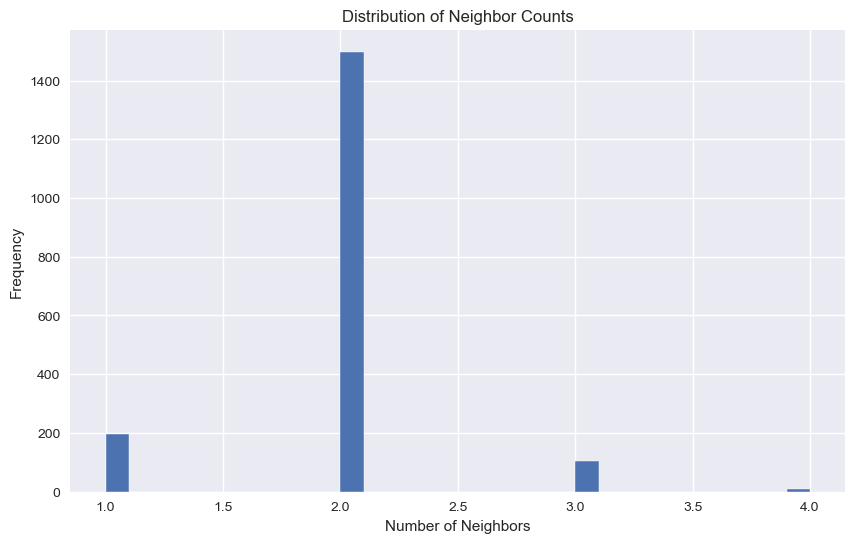

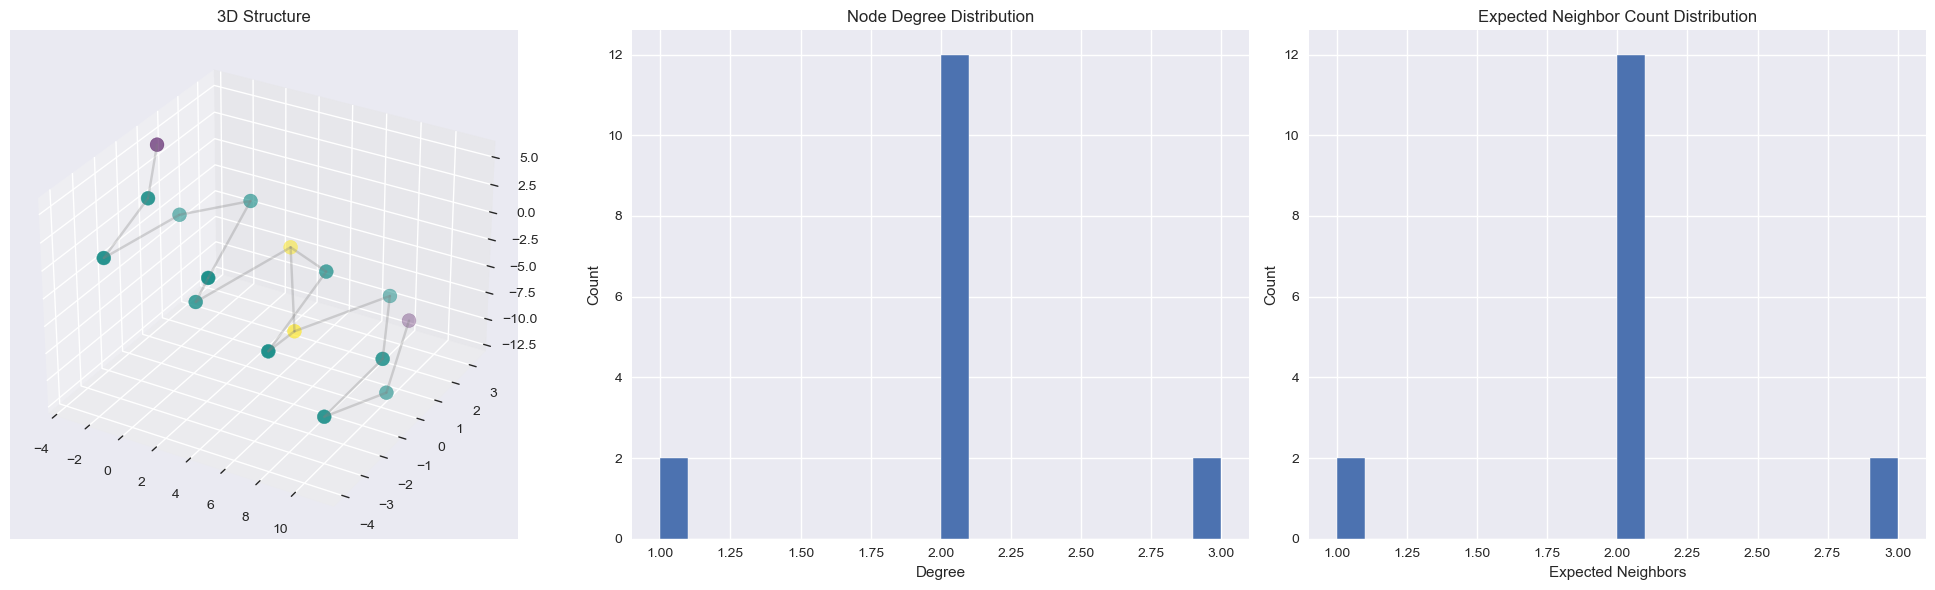


Graph 0 Statistics:
Number of nodes: 16
Number of edges: 64
Average neighbor count: 2.00
Average degree: 2.00

No validation issues found.


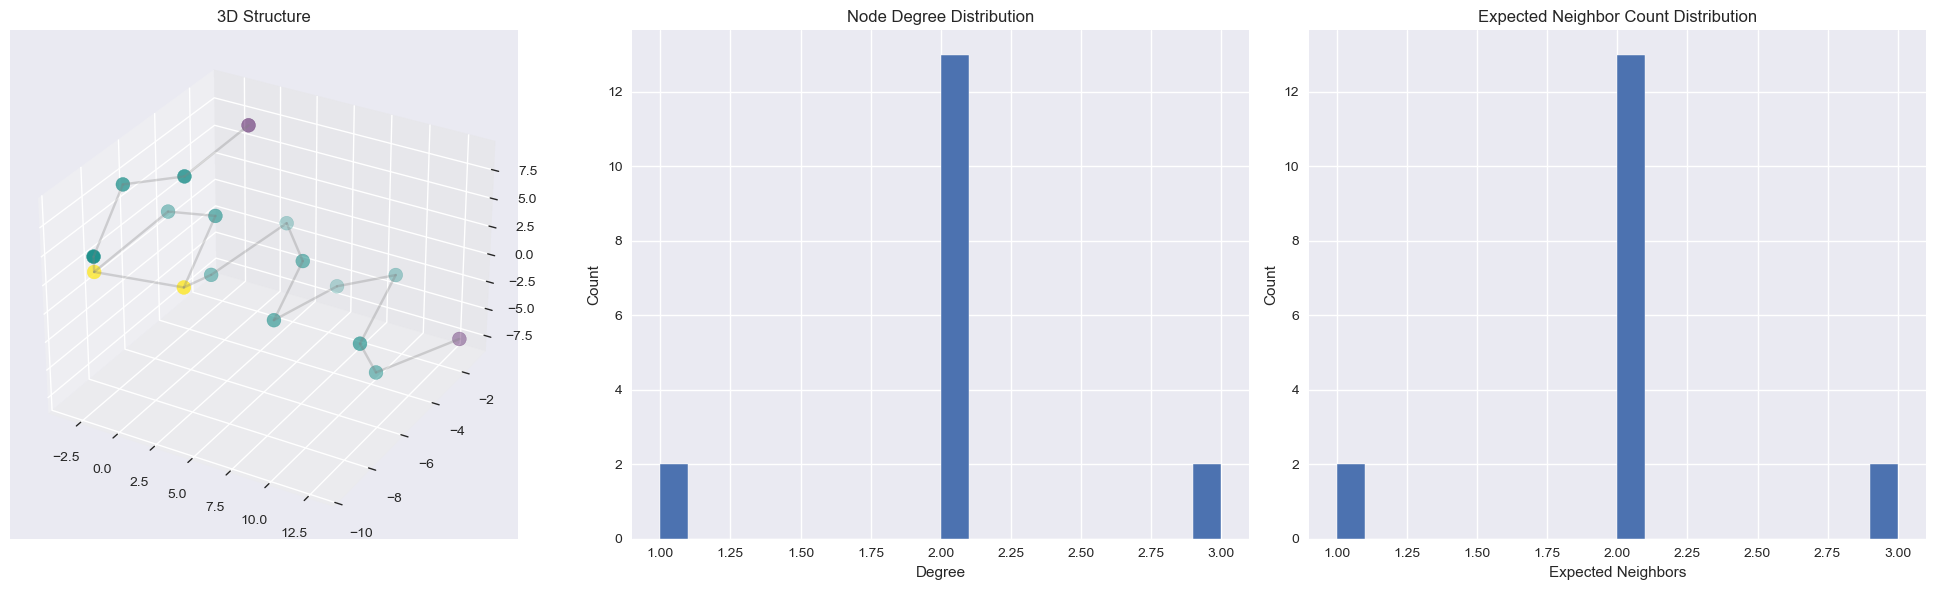


Graph 1 Statistics:
Number of nodes: 17
Number of edges: 68
Average neighbor count: 2.00
Average degree: 2.00

No validation issues found.


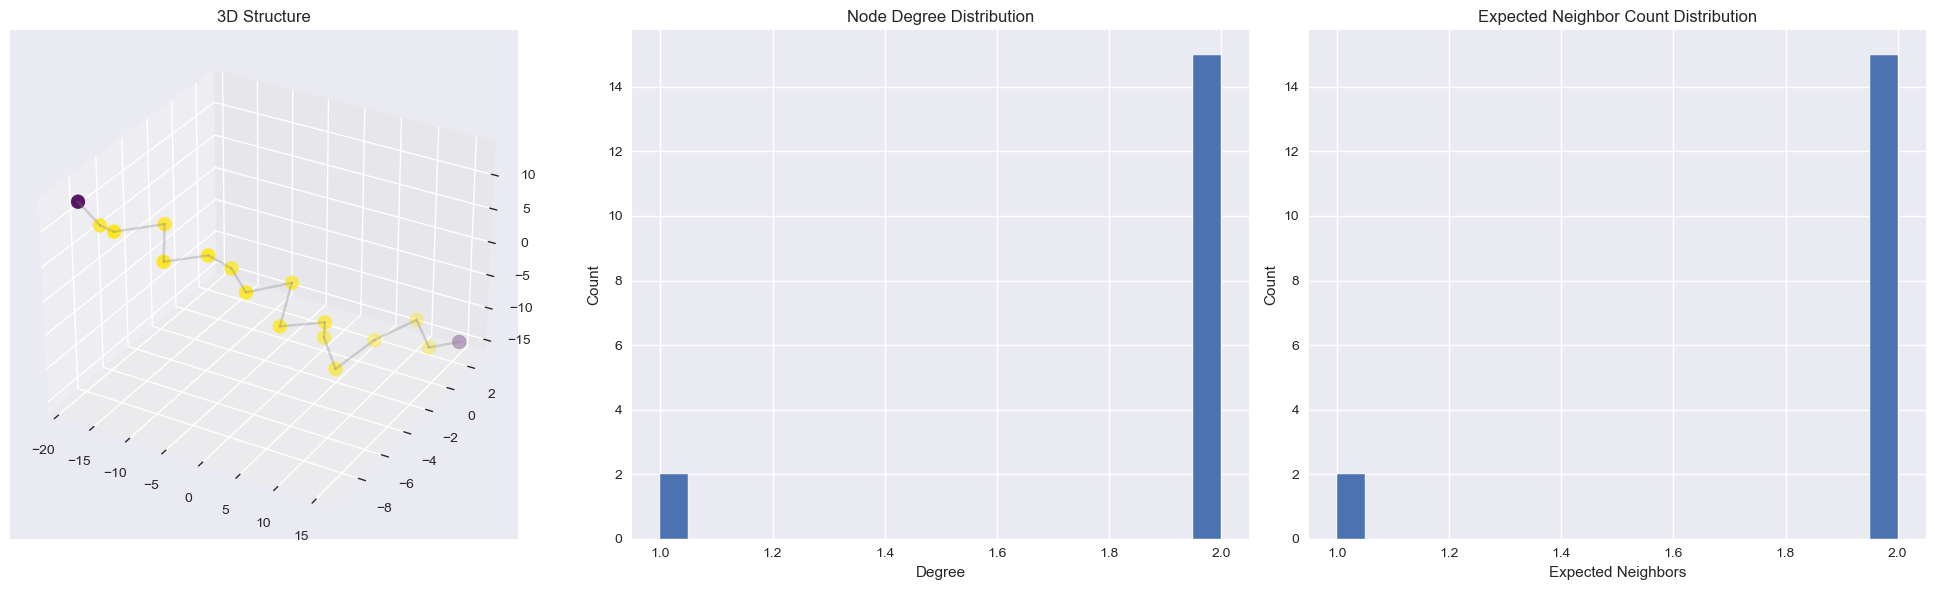

INFO:__main__:Split dataset into 80 training and 20 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 18.14
INFO:__main__:Average edges: 70.95
INFO:__main__:Average neighbors: 1.96
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 17.80
INFO:__main__:Average edges: 70.40
INFO:__main__:Average neighbors: 1.98
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 3
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 32
INFO:__main__:Total nodes: 586
INFO:__main__:Total edges: 2264
INFO:__main__:Feature dimension: 3



Graph 2 Statistics:
Number of nodes: 17
Number of edges: 64
Average neighbor count: 1.88
Average degree: 1.88

No validation issues found.


In [9]:
# Create graphs with validation
graphs = create_graphs_from_df_array(autoencoder_input_dfs)

# Validate first few graphs
for i in range(min(3, len(graphs))):
    visualize_protein_graph(graphs[i], i)

# If graphs look good, proceed with splitting and loader creation
train_graphs, val_graphs = split_dataset(graphs)
train_loader, val_loader = create_data_loaders(train_graphs, val_graphs)

In [10]:
class MolecularGVAE(nn.Module):
    def __init__(self, node_features=3, hidden_dim=64, latent_dim=32, num_neighbors=3):
        super(MolecularGVAE, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_neighbors = num_neighbors

        # Encoder
        self.enc_conv1 = GATv2Conv(node_features, hidden_dim)
        self.enc_conv2 = GATv2Conv(hidden_dim, hidden_dim)
        self.enc_norm1 = nn.GroupNorm(8, hidden_dim)
        self.enc_norm2 = nn.GroupNorm(8, hidden_dim)

        # Latent space
        self.node_mu = nn.Linear(hidden_dim, latent_dim)
        self.node_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder for node features
        self.dec_node_features = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, node_features)
        )

        # Edge prediction with stable initialization
        self.edge_pred = nn.Sequential(
            nn.Linear(4 * latent_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Initialize the last layer with bias towards edge formation
        self.edge_pred[-1].bias.data.fill_(1.0)
        self.edge_pred[-1].weight.data.normal_(0, 0.01)

    def decode(self, z, edge_index, num_nodes):
        """
        Decoder with correct edge counting
        """
        node_features = self.dec_node_features(z)
        neighbor_context = self.compute_neighbor_context(z, edge_index)

        # Calculate target number of edges (counting undirected edges once)
        target_edges = edge_index.size(1) // 4  # Divide by 4 because each edge is counted twice in both directions

        # Create backbone edges
        backbone_edges = []
        for i in range(num_nodes - 1):
            backbone_edges.extend([(i, i+1), (i+1, i)])
        backbone_edges = torch.tensor(backbone_edges, device=z.device).t()

        # Calculate remaining edges needed
        num_backbone = (num_nodes - 1)  # Count backbone edges once
        spatial_edges_needed = target_edges - num_backbone

        if spatial_edges_needed > 0:
            # Create non-backbone edge predictions
            candidate_edges = []
            edge_scores = []

            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    if abs(i - j) != 1:  # Skip backbone edges
                        candidate_edges.append((i, j))
                        edge_feature = torch.cat([
                            z[i], z[j],
                            neighbor_context[i], neighbor_context[j]
                        ])
                        score = self.edge_pred(edge_feature.unsqueeze(0)).squeeze()
                        edge_scores.append(score)

            if edge_scores:
                edge_scores = torch.stack(edge_scores)
                # Select top k edges
                _, top_indices = torch.topk(edge_scores, min(spatial_edges_needed, len(edge_scores)))

                # Add selected edges in both directions
                spatial_edges = []
                for idx in top_indices:
                    i, j = candidate_edges[idx]
                    spatial_edges.extend([(i, j), (j, i)])

                spatial_edges = torch.tensor(spatial_edges, device=z.device).t()
                final_edge_index = torch.cat([backbone_edges, spatial_edges], dim=1)
            else:
                final_edge_index = backbone_edges
        else:
            final_edge_index = backbone_edges

        # Create edge logits
        edge_logits = torch.zeros((num_nodes, num_nodes), device=z.device)
        edge_logits[final_edge_index[0], final_edge_index[1]] = 10.0  # Selected edges

        return node_features, edge_logits, neighbor_context, final_edge_index

    def loss_function(self, node_features, edge_logits, neighbor_context, data, node_mu, node_logvar, kl_weight=1.0):
        """
        Loss function with proper target normalization
        """
        # Node feature reconstruction loss (normalized)
        norm_node_features = F.normalize(node_features, p=2, dim=1)
        norm_true_features = F.normalize(data.x, p=2, dim=1)
        node_recon_loss = F.mse_loss(norm_node_features, norm_true_features)

        # Get adjacency matrix and ensure it's binary
        true_adj = to_dense_adj(data.edge_index, max_num_nodes=data.x.size(0))[0]
        true_adj = (true_adj > 0).float()  # Convert to binary 0/1
        num_nodes = data.x.size(0)

        # Create backbone mask
        backbone_mask = torch.zeros_like(true_adj)
        for i in range(num_nodes - 1):
            backbone_mask[i, i+1] = 1
            backbone_mask[i+1, i] = 1
        backbone_mask = backbone_mask.float()

        # Edge predictions
        pred_probs = torch.sigmoid(edge_logits)

        # Ensure targets are binary and between 0 and 1
        backbone_targets = true_adj[backbone_mask > 0].clamp(0, 1)
        backbone_preds = pred_probs[backbone_mask > 0]

        # Backbone loss
        if len(backbone_targets) > 0:
            backbone_loss = F.binary_cross_entropy(
                backbone_preds,
                backbone_targets,
                reduction='mean'
            ) * 0.1
        else:
            backbone_loss = torch.tensor(0.0).to(edge_logits.device)

        # Non-backbone edge loss
        non_backbone_mask = (1 - backbone_mask) * (true_adj > 0)
        non_backbone_targets = true_adj[non_backbone_mask > 0].clamp(0, 1)
        non_backbone_preds = pred_probs[non_backbone_mask > 0]

        if len(non_backbone_targets) > 0:
            non_backbone_loss = F.binary_cross_entropy(
                non_backbone_preds,
                non_backbone_targets,
                reduction='mean'
            ) * 0.1
        else:
            non_backbone_loss = torch.tensor(0.0).to(edge_logits.device)

        # Edge count matching (normalized)
        target_edges = data.edge_index.size(1) // 2
        pred_edges = pred_probs.sum() / 2
        max_possible_edges = (num_nodes * (num_nodes - 1)) // 2
        edge_count_loss = F.mse_loss(
            pred_edges / max_possible_edges,
            torch.tensor(target_edges / max_possible_edges).to(edge_logits.device)
        )

        # KL divergence (scaled)
        kl_loss = -0.5 * torch.mean(1 + node_logvar - node_mu.pow(2) - node_logvar.exp())
        kl_loss = torch.clamp(kl_loss * 0.01, max=1.0)  # Scale and clamp KL loss

        # Combined loss
        total_loss = (
                0.1 * node_recon_loss +     # Node features
                1.0 * backbone_loss +       # Backbone connections
                0.5 * non_backbone_loss +   # Non-backbone connections
                1.0 * edge_count_loss +     # Edge count matching
                0.01 * kl_weight * kl_loss  # KL divergence
        )

        # Return loss and metrics
        return total_loss, {
            'total': total_loss.item(),
            'node_recon': node_recon_loss.item(),
            'backbone': backbone_loss.item(),
            'non_backbone': non_backbone_loss.item(),
            'edge_count': edge_count_loss.item(),
            'kl': kl_loss.item(),
            'pred_edges': pred_edges.item(),
            'target_edges': float(target_edges),
            'max_prob': pred_probs.max().item(),
            'min_prob': pred_probs.min().item(),
            'avg_prob': pred_probs.mean().item()
        }

    def initialize_weights(self):
        """
        Proper weight initialization
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def compute_neighbor_context(self, z, edge_index):
        """Compute context vector based on neighboring nodes"""
        num_nodes = z.size(0)
        neighbor_context = torch.zeros(num_nodes, self.latent_dim, device=z.device)

        if edge_index.size(1) > 0:
            for node_idx in range(num_nodes):
                mask = (edge_index[0] == node_idx)
                neighbors = edge_index[1][mask]

                if len(neighbors) > 0:
                    neighbor_embeds = z[neighbors]
                    neighbor_context[node_idx] = neighbor_embeds.mean(dim=0)

        return neighbor_context

    def encode(self, data):
        x, edge_index = data.x, data.edge_index

        if x.device.type == 'mps':
            x = x.cpu()
            edge_index = edge_index.cpu()

        h = self.enc_conv1(x, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm1(h))
        h = self.enc_conv2(h, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm2(h))

        h = h.to(data.x.device)

        return self.node_mu(h), self.node_logvar(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparameterize(mu, logvar)
        node_features, edge_logits, neighbor_context, final_edge_index = self.decode(
            z, data.edge_index, data.x.size(0)
        )
        return node_features, edge_logits, neighbor_context, final_edge_index





    def calc_edge_accuracy(self, edge_logits, true_adj):
        """
        Calculate edge prediction accuracy metrics
        """
        pred_adj = (torch.sigmoid(edge_logits) > 0.5).float()

        # Overall accuracy
        accuracy = (pred_adj == true_adj).float().mean()

        # Precision and recall for positive class
        true_positives = (pred_adj * true_adj).sum()
        pred_positives = pred_adj.sum()
        real_positives = true_adj.sum()

        precision = true_positives / (pred_positives + 1e-6)
        recall = true_positives / (real_positives + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        return {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1.item()
        }



In [11]:
class TrainingManager:
    def __init__(self, model_name, checkpoint_dir='checkpoints'):
        self.model_name = model_name
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)

        self.train_metrics = defaultdict(list)
        self.val_metrics = defaultdict(list)
        self.best_val_loss = float('inf')
        self.run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    def save_checkpoint(self, epoch, model, optimizer, train_loss, val_loss, metrics):
        checkpoint_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_epoch{epoch}.pt"
        metrics_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_metrics.json"

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metrics': dict(self.train_metrics),
            'val_metrics': dict(self.val_metrics)
        }
        torch.save(checkpoint, checkpoint_path)

        metrics_dict = {
            'train': dict(self.train_metrics),
            'val': dict(self.val_metrics)
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics_dict, f, indent=4)

        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            best_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_best.pt"
            torch.save(checkpoint, best_path)
            logger.info(f"\nNew best model saved with validation loss: {val_loss:.4f}")

    def update_metrics(self, epoch_metrics, phase='train'):
        metrics_dict = self.train_metrics if phase == 'train' else self.val_metrics
        for key, value in epoch_metrics.items():
            metrics_dict[key].append(value)

    def plot_training_progress(self):
        metrics = list(self.train_metrics.keys())
        n_metrics = len(metrics)

        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        if n_metrics == 1:
            axes = [axes]

        for ax, metric in zip(axes, metrics):
            train_values = self.train_metrics[metric]
            ax.plot(train_values, label=f'Train {metric}', color='blue', alpha=0.7)

            if metric in self.val_metrics:
                val_values = self.val_metrics[metric]
                ax.plot(val_values, label=f'Val {metric}', color='red', alpha=0.7)

            ax.set_title(f'{metric} over Training')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()

        plt.tight_layout()
        plt.show()

In [12]:
def compute_edge_stats(edge_index, num_nodes):
    """
    Compute edge statistics properly handling undirected edges
    
    Args:
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        num_nodes: Number of nodes in the graph
    """
    # Convert to set of undirected edges (always store smaller index first)
    edges = set()
    for i, j in zip(edge_index[0].tolist(), edge_index[1].tolist()):
        if i != j:  # Exclude self-loops
            edges.add((min(i, j), max(i, j)))

    # Create set of backbone edges
    backbone_edges = set((i, i+1) for i in range(num_nodes - 1))

    # Find backbone edges that are present
    backbone_present = edges.intersection(backbone_edges)

    # Calculate spatial edges (non-backbone)
    spatial_edges = edges - backbone_edges

    # Calculate degree distribution (counting each edge twice for undirected graph)
    degree_count = defaultdict(int)
    for i, j in edges:
        degree_count[i] += 1
        degree_count[j] += 1

    # Compute statistics
    total_edges = len(edges)  # Each edge counted once
    backbone_count = len(backbone_present)
    spatial_count = len(spatial_edges)

    # Check backbone completeness
    expected_backbone = num_nodes - 1
    missing_backbone = set(range(num_nodes-1)) - set(i for i, _ in backbone_present)

    stats = {
        'total_edges': total_edges,
        'backbone_edges': backbone_count,
        'spatial_edges': spatial_count,
        'average_degree': sum(degree_count.values()) / num_nodes,
        'max_degree': max(degree_count.values()) if degree_count else 0,
        'backbone_complete': len(backbone_present) == expected_backbone,
        'missing_backbone': sorted(list(missing_backbone))
    }

    return stats

def log_edge_stats(pred_stats, target_stats):
    """
    Improved edge statistics logging
    """
    logger.info("\nEdge Statistics:")
    logger.info(f"{'Metric':15s} {'Predicted':>10s} {'Target':>10s} {'Match?':>8s}")
    logger.info("-" * 45)

    metrics = [
        ('total_edges', 'Total Edges'),
        ('backbone_edges', 'Backbone Edges'),
        ('spatial_edges', 'Spatial Edges'),
        ('average_degree', 'Avg Degree')
    ]

    for key, label in metrics:
        if key == 'average_degree':
            match = abs(pred_stats[key] - target_stats[key]) < 0.1
            logger.info(f"{label:15s} {pred_stats[key]:10.2f} {target_stats[key]:10.2f} {'✓' if match else '✗':>8s}")
        else:
            match = pred_stats[key] == target_stats[key]
            logger.info(f"{label:15s} {pred_stats[key]:10d} {target_stats[key]:10d} {'✓' if match else '✗':>8s}")

    logger.info(f"\nBackbone Status:")
    logger.info(f"Predicted: {'Complete' if pred_stats['backbone_complete'] else 'Incomplete'}")
    logger.info(f"Target: {'Complete' if target_stats['backbone_complete'] else 'Incomplete'}")

    if not pred_stats['backbone_complete']:
        logger.warning(f"Missing predicted backbone edges: {pred_stats['missing_backbone']}")
    if not target_stats['backbone_complete']:
        logger.warning(f"Missing target backbone edges: {target_stats['missing_backbone']}")


In [13]:
def train_model(model, train_loader, val_loader, initial_lr=1e-3, n_epochs=100, device='cpu',
                patience=20, checkpoint_frequency=5, plot_frequency=1, max_grad_norm=1.0):
    """
    Complete training loop with fixed edge counting and improved logging
    """
    # Initialize training components
    manager = TrainingManager('molecular_gvae')
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
    )

    # KL annealing setup
    kl_weight = lambda epoch: min(1.0, (epoch + 1) / (n_epochs * 0.2))

    # Training state
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_edge_count': [], 'val_edge_count': [],
        'target_edge_count': [], 'kl_weight': [],
        'learning_rate': [], 'backbone_accuracy': []
    }

    # Create directories for outputs
    os.makedirs('training_plots', exist_ok=True)
    os.makedirs('checkpoints', exist_ok=True)

    # Log initial setup
    logger.info("\nTraining Setup:")
    logger.info(f"Initial learning rate: {initial_lr}")
    logger.info(f"Max epochs: {n_epochs}")
    logger.info(f"Patience: {patience}")
    logger.info(f"Device: {device}")

    # Main training loop
    for epoch in range(n_epochs):
        current_kl_weight = kl_weight(epoch)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"\nEpoch {epoch+1}/{n_epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_metrics = defaultdict(float)
        epoch_edge_counts = []
        epoch_backbone_accuracy = []

        with tqdm(train_loader, desc='Training') as train_pbar:
            for batch_idx, batch in enumerate(train_pbar):
                batch = batch.to(device)
                optimizer.zero_grad()

                # Forward pass
                node_features, edge_logits, neighbor_context, final_edge_index = model(batch)
                mu, logvar = model.encode(batch)

                # Calculate loss
                loss, batch_metrics = model.loss_function(
                    node_features, edge_logits, neighbor_context,
                    batch, mu, logvar,
                    kl_weight=current_kl_weight
                )

                # Log edge stats for first batch
                if batch_idx == 0:
                    pred_stats = compute_edge_stats(final_edge_index, batch.x.size(0))
                    target_stats = compute_edge_stats(batch.edge_index, batch.x.size(0))
                    log_edge_stats(pred_stats, target_stats)

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update metrics
                train_loss += loss.item()
                for k, v in batch_metrics.items():
                    train_metrics[k] += v

                # Track edge statistics
                edge_stats = compute_edge_stats(final_edge_index, batch.x.size(0))
                target_stats = compute_edge_stats(batch.edge_index, batch.x.size(0))

                epoch_edge_counts.append(edge_stats['total_edges'])
                epoch_backbone_accuracy.append(
                    1.0 if edge_stats['backbone_complete'] else
                    edge_stats['backbone_edges'] / (batch.x.size(0) - 1)
                )

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'edges': f"{edge_stats['total_edges']}/{target_stats['total_edges']}",
                    'backbone': 'Complete' if edge_stats['backbone_complete'] else 'Incomplete'
                })

        # Calculate training averages
        avg_train_loss = train_loss / len(train_loader)
        avg_train_metrics = {k: v / len(train_loader) for k, v in train_metrics.items()}
        avg_train_edge_count = np.mean(epoch_edge_counts)
        avg_backbone_accuracy = np.mean(epoch_backbone_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0
        val_metrics = defaultdict(float)
        val_edge_counts = []
        val_backbone_accuracy = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                batch = batch.to(device)

                # Forward pass
                node_features, edge_logits, neighbor_context, final_edge_index = model(batch)
                mu, logvar = model.encode(batch)

                # Calculate loss
                loss, batch_metrics = model.loss_function(
                    node_features, edge_logits, neighbor_context,
                    batch, mu, logvar,
                    kl_weight=current_kl_weight
                )

                # Update metrics
                val_loss += loss.item()
                for k, v in batch_metrics.items():
                    val_metrics[k] += v

                # Track edge statistics
                edge_stats = compute_edge_stats(final_edge_index, batch.x.size(0))
                val_edge_counts.append(edge_stats['total_edges'])
                val_backbone_accuracy.append(
                    1.0 if edge_stats['backbone_complete'] else
                    edge_stats['backbone_edges'] / (batch.x.size(0) - 1)
                )

                # Log first batch stats
                if batch_idx == 0:
                    pred_stats = compute_edge_stats(final_edge_index, batch.x.size(0))
                    target_stats = compute_edge_stats(batch.edge_index, batch.x.size(0))
                    logger.info("\nValidation Batch Statistics:")
                    log_edge_stats(pred_stats, target_stats)

        # Calculate validation averages
        avg_val_loss = val_loss / len(val_loader)
        avg_val_metrics = {k: v / len(val_loader) for k, v in val_metrics.items()}
        avg_val_edge_count = np.mean(val_edge_counts)
        avg_val_backbone_accuracy = np.mean(val_backbone_accuracy)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_edge_count'].append(avg_train_edge_count)
        history['val_edge_count'].append(avg_val_edge_count)
        history['target_edge_count'].append(target_stats['total_edges'])
        history['kl_weight'].append(current_kl_weight)
        history['learning_rate'].append(current_lr)
        history['backbone_accuracy'].append(avg_backbone_accuracy)

        # Plot training progress
        if (epoch + 1) % plot_frequency == 0:
            plot_training_metrics(history, epoch + 1)

        # Print epoch summary
        logger.info("\nEpoch Summary:")
        logger.info(f"{'Train Loss':15s}: {avg_train_loss:.4f}")
        logger.info(f"{'Val Loss':15s}: {avg_val_loss:.4f}")
        logger.info(f"{'Train Edges':15s}: {avg_train_edge_count:.1f}")
        logger.info(f"{'Val Edges':15s}: {avg_val_edge_count:.1f}")
        logger.info(f"{'Backbone Acc':15s}: {avg_backbone_accuracy:.3f}")
        logger.info(f"{'Learning Rate':15s}: {current_lr:.6f}")

        # Save checkpoint
        if (epoch + 1) % checkpoint_frequency == 0:
            manager.save_checkpoint(
                epoch,
                model,
                optimizer,
                avg_train_metrics['total'],
                avg_val_metrics['total'],
                {
                    'train': avg_train_metrics,
                    'val': avg_val_metrics,
                    'backbone_accuracy': avg_backbone_accuracy,
                    'edge_counts': {
                        'train': avg_train_edge_count,
                        'val': avg_val_edge_count,
                        'target': target_stats['total_edges']
                    }
                }
            )

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            logger.info(f"New best validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Check for early stopping
        if patience_counter >= patience:
            logger.info(f"\nEarly stopping triggered after {epoch + 1} epochs")
            model.load_state_dict(best_model_state)
            break

    # Final plot
    plot_training_metrics(history)

    return manager, history


In [14]:
def plot_training_metrics(history, epoch=None):
    """
    Plot training metrics with optional epoch specification
    
    Args:
        history: Dictionary containing training history
        epoch: Optional epoch number for saving with epoch info
    """
    plt.figure(figsize=(20, 10))

    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)

    # Edge count plot
    plt.subplot(2, 2, 2)
    if 'train_edge_count' in history:
        plt.plot(history['train_edge_count'], label='Train Predicted')
    if 'val_edge_count' in history:
        plt.plot(history['val_edge_count'], label='Val Predicted')
    if 'target_edge_count' in history:
        plt.plot(history['target_edge_count'], label='Target', linestyle='--')
    plt.title('Edge Count vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Edges')
    plt.legend()
    plt.grid(True)

    # KL weight plot
    plt.subplot(2, 2, 3)
    if 'kl_weight' in history:
        plt.plot(history['kl_weight'])
        plt.title('KL Weight vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('KL Weight')
        plt.grid(True)

    # Learning rate plot
    plt.subplot(2, 2, 4)
    if 'learning_rate' in history:
        plt.plot(history['learning_rate'])
        plt.title('Learning Rate vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)

    plt.tight_layout()

    # Create plots directory if it doesn't exist
    os.makedirs('training_plots', exist_ok=True)

    # Save plot with appropriate filename
    if epoch is not None:
        plt.savefig(f'training_plots/training_metrics_epoch_{epoch}.png')
    else:
        plt.savefig('training_plots/final_training_metrics.png')

    plt.close()

    
    
def plot_latent_space(model, loader, device):
    """Visualize the latent space using PCA"""
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())

            # Get the degree of each node as a simple structural feature
            degrees = torch.zeros(batch.x.size(0))
            unique_nodes, counts = torch.unique(batch.edge_index[0], return_counts=True)
            degrees[unique_nodes] = counts.float()
            labels.append(degrees.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA visualization
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                          c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Node Degree')
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

INFO:__main__:Starting data processing pipeline...


Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:__main__:Successfully created 100 graphs out of 100 input structures
INFO:__main__:Average nodes per graph: 18.07
INFO:__main__:Average edges per graph: 70.84
INFO:__main__:Average neighbors per node: 1.96
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 4
INFO:__main__:Mean neighbors: 1.96
INFO:__main__:Median neighbors: 2


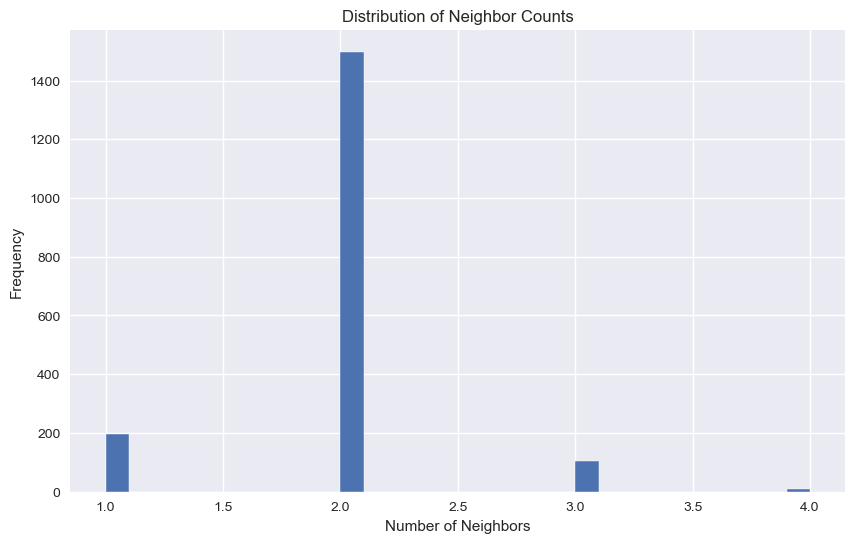

INFO:__main__:Created 100 graphs
INFO:__main__:Split dataset into 80 training and 20 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 18.14
INFO:__main__:Average edges: 70.95
INFO:__main__:Average neighbors: 1.96
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 17.80
INFO:__main__:Average edges: 70.40
INFO:__main__:Average neighbors: 1.98
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 3
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 32
INFO:__main__:Total nodes: 585
INFO:__main__:Total edges: 2284
INFO:__main__:Feature dimension: 3
INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility
INFO:__main__:Starting data processing pipeline...


Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:__main__:Successfully created 100 graphs out of 100 input structures
INFO:__main__:Average nodes per graph: 18.07
INFO:__main__:Average edges per graph: 70.84
INFO:__main__:Average neighbors per node: 1.96
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 4
INFO:__main__:Mean neighbors: 1.96
INFO:__main__:Median neighbors: 2


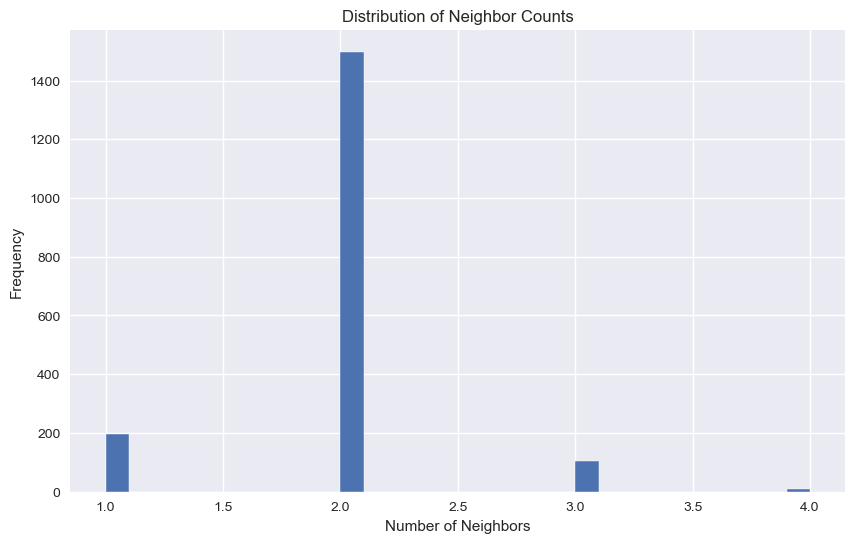

INFO:__main__:Created 100 graphs
INFO:__main__:Split dataset into 80 training and 20 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 18.14
INFO:__main__:Average edges: 70.95
INFO:__main__:Average neighbors: 1.96
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 17.80
INFO:__main__:Average edges: 70.40
INFO:__main__:Average neighbors: 1.98
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 3
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 32
INFO:__main__:Total nodes: 572
INFO:__main__:Total edges: 2244
INFO:__main__:Feature dimension: 3



Sample batch properties:
Number of graphs: 32
Number of nodes: 571
Number of edges: 2228


In [17]:
data = process_and_load_data(autoencoder_input_dfs)
normalizer = data['normalizer']

# Define the device variable
device = get_device()

# Process all data with normalization
data = process_and_load_data(
    df_array=autoencoder_input_dfs,
    batch_size=32,
    train_ratio=0.8
)

# Access the normalized data and normalizer
train_loader = data['train_loader']
val_loader = data['val_loader']
num_node_features = data['num_node_features']
normalizer = data['normalizer']  # Save this for later use with generator

# Initialize and train model with normalized data
model = MolecularGVAE(
    node_features=num_node_features,
    hidden_dim=64,
    latent_dim=32,
    num_neighbors=3
).to(device)

# Verify data loading
for batch in itertools.islice(train_loader, 1):
    print("\nSample batch properties:")
    print(f"Number of graphs: {batch.num_graphs}")
    print(f"Number of nodes: {batch.x.size(0)}")
    print(f"Number of edges: {batch.edge_index.size(1)}")
    break

In [18]:
import time
from datetime import datetime

def main():
    """
    Main training function with cleaner logging
    """
    # Set up logging with cleaner format
    logging.basicConfig(
        level=logging.INFO,
        format='%(message)s',  # Simplified format
        handlers=[
            logging.FileHandler('training.log'),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)

    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('plots', exist_ok=True)
    os.makedirs('checkpoints', exist_ok=True)

    try:
        # Device setup
        device = get_device()
        logger.info(f"\nDevice: {device}")

        # Initialize model
        model = MolecularGVAE(
            node_features=train_graphs[0].x.size(1),
            hidden_dim=64,
            latent_dim=32,
            num_neighbors=3
        ).to(device)

        # Log model summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        logger.info("\nModel Summary:")
        logger.info("-" * 40)
        logger.info(f"Input features: {train_graphs[0].x.size(1)}")
        logger.info(f"Hidden dim: 64")
        logger.info(f"Latent dim: 32")
        logger.info(f"Total parameters: {total_params:,}")
        logger.info(f"Trainable parameters: {trainable_params:,}")

        # Log parameter shapes in a table format
        if logging.getLogger().isEnabledFor(logging.DEBUG):  # Only log if debug is enabled
            logger.debug("\nModel Parameters:")
            logger.debug("-" * 50)
            logger.debug(f"{'Layer':30s} {'Shape':>20s}")
            logger.debug("-" * 50)
            for name, param in model.named_parameters():
                logger.debug(f"{name:30s} {str(tuple(param.shape)):>20s}")

        # Training configuration
        training_config = {
            'initial_lr': 0.0001,
            'n_epochs': 400,
            'max_grad_norm': 0.1,
            'patience': 20,
            'plot_frequency': 20
        }

        # Log training setup
        logger.info("\nTraining Configuration:")
        logger.info("-" * 40)
        for key, value in training_config.items():
            logger.info(f"{key:15s}: {value}")

        # Dataset info
        logger.info("\nDataset Information:")
        logger.info("-" * 40)
        logger.info(f"Training samples: {len(train_loader.dataset):,}")
        logger.info(f"Validation samples: {len(val_loader.dataset):,}")

        # Start training
        logger.info("\nStarting training...")
        start_time = time.time()

        # Train model
        manager, history = train_model(
            model,
            train_loader,
            val_loader,
            **training_config
        )

        # Log training completion
        training_time = time.time() - start_time
        logger.info(f"\nTraining completed in {training_time/60:.2f} minutes")

        # Save model
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = f'models/model_{timestamp}.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'config': training_config
        }, save_path)
        logger.info(f"Model saved to {save_path}")

        return model, history

    except Exception as e:
        logger.error("Training failed:", exc_info=True)
        raise e



model, history = main()


INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility
INFO:__main__:
Device: cpu
INFO:__main__:
Model Summary:
INFO:__main__:----------------------------------------
INFO:__main__:Input features: 3
INFO:__main__:Hidden dim: 64
INFO:__main__:Latent dim: 32
INFO:__main__:Total parameters: 30,788
INFO:__main__:Trainable parameters: 30,788
INFO:__main__:
Training Configuration:
INFO:__main__:----------------------------------------
INFO:__main__:initial_lr     : 0.0001
INFO:__main__:n_epochs       : 400
INFO:__main__:max_grad_norm  : 0.1
INFO:__main__:patience       : 20
INFO:__main__:plot_frequency : 20
INFO:__main__:
Dataset Information:
INFO:__main__:----------------------------------------
INFO:__main__:Training samples: 80
INFO:__main__:Validation samples: 20
INFO:__main__:
Starting training...
/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        577        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        562        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         10        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        569        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        565        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        568        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        574        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        565        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        554        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        569        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        555        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        561        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        571        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        570        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        567        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            593        585        ✗
INFO:__main__:Backbone Edges         593        562        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        581        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        555        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            594        580        ✗
INFO:__main__:Backbone Edges         594        563        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        584        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        561        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        566        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        565        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        559        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        566        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        576        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        559        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        578        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        571        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        562        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        553        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        585        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         29        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        568        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        571        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        561        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         10        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        570        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        567        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            566        560        ✗
INFO:__main__:Backbone Edges         566        535        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        559        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            602        598        ✗
INFO:__main__:Backbone Edges         602        571        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        570        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        573        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        578        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        572        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        575        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        559        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        564        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        583        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         30        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        588        ✓
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         31        ✗
INFO:__main__:Avg Degree            2.00       2.00        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        562        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        582        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        549        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        568        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        579        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        567        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        569        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            569        563        ✗
INFO:__main__:Backbone Edges         569        538        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        556        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        566        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        574        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        576        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        562        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        575        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        578        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        569        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        565        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        574        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        565        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        574        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        568        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        563        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        556        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        555        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        578        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            569        563        ✗
INFO:__main__:Backbone Edges         569        538        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        576        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        566        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        560        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        563        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        575        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        567        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        569        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        563        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        566        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        554        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        556        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        560        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        580        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        562        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        560        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        574        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        578        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        554        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        563        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        563        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        572        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        573        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        558        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        573        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        565        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        565        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        577        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        567        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        580        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        577        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        569        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        573        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        556        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        570        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        568        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        584        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        568        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        571        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        573        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        576        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        572        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        560        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0          8        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        556        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            566        548        ✗
INFO:__main__:Backbone Edges         566        535        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        564        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        562        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        571        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        563        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            563        546        ✗
INFO:__main__:Backbone Edges         563        532        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        560        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        565        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            562        559        ✗
INFO:__main__:Backbone Edges         562        531        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        562        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        571        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        575        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        565        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        576        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        566        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        570        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            561        548        ✗
INFO:__main__:Backbone Edges         561        530        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        568        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        567        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        579        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        583        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        562        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        579        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        581        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         29        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        555        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        574        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            569        567        ✗
INFO:__main__:Backbone Edges         569        538        ✗
INFO:__main__:Spatial Edges            0         29        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        565        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        569        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        561        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        567        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        564        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        573        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            569        561        ✗
INFO:__main__:Backbone Edges         569        538        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        577        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        570        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        560        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        574        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        578        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            597        585        ✗
INFO:__main__:Backbone Edges         597        566        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        567        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        569        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        562        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        571        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        570        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        576        ✓
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         31        ✗
INFO:__main__:Avg Degree            2.00       2.00        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            561        548        ✗
INFO:__main__:Backbone Edges         561        530        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        576        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        558        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        573        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        569        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        557        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            565        549        ✗
INFO:__main__:Backbone Edges         565        534        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        569        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        571        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        564        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        563        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        580        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        576        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        570        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        560        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        565        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        557        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        565        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            595        579        ✗
INFO:__main__:Backbone Edges         595        564        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        562        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        570        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        557        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        558        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        551        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        552        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        580        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        561        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        565        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        581        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        575        ✓
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         31        ✗
INFO:__main__:Avg Degree            2.00       2.00        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        563        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            566        549        ✗
INFO:__main__:Backbone Edges         566        535        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            593        576        ✗
INFO:__main__:Backbone Edges         593        562        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        560        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        571        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        572        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            567        559        ✗
INFO:__main__:Backbone Edges         567        536        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        566        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        558        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        576        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        558        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        579        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        576        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        556        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        570        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        554        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        572        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        559        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        575        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        568        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        561        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        556        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        561        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        575        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        567        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            563        558        ✗
INFO:__main__:Backbone Edges         563        532        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        578        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        573        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        559        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        578        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        566        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        568        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        564        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        562        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        558        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        584        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         30        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        566        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            565        553        ✗
INFO:__main__:Backbone Edges         565        534        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            594        575        ✗
INFO:__main__:Backbone Edges         594        563        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        562        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        570        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        573        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        552        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        568        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            593        585        ✗
INFO:__main__:Backbone Edges         593        562        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        566        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        558        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        560        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            568        552        ✗
INFO:__main__:Backbone Edges         568        537        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        584        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        570        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        563        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        563        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        567        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        559        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        567        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        572        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        566        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        577        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        576        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        564        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        579        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        582        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        559        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        573        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        551        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        561        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        562        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        572        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        573        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        563        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        569        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        564        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        554        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        567        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        583        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        570        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        564        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        567        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        565        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        572        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        567        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        565        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        565        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        570        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            561        558        ✗
INFO:__main__:Backbone Edges         561        530        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        569        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        572        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        557        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        573        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        576        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        576        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        561        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        561        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            562        550        ✗
INFO:__main__:Backbone Edges         562        531        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        563        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        572        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            567        562        ✗
INFO:__main__:Backbone Edges         567        536        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        567        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        573        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        558        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        571        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        566        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        572        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        577        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            593        590        ✗
INFO:__main__:Backbone Edges         593        562        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        574        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        564        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         10        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        560        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        564        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        578        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        564        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        560        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        558        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        566        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        565        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        571        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        557        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        571        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            566        551        ✗
INFO:__main__:Backbone Edges         566        535        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            567        558        ✗
INFO:__main__:Backbone Edges         567        536        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        569        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        564        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        560        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        568        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        560        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        561        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        565        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        564        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        565        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        561        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        576        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        579        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        578        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        566        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            564        552        ✗
INFO:__main__:Backbone Edges         564        533        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        568        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        576        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        572        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        569        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         25        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        561        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        564        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        574        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        574        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         27        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        557        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        582        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        567        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        564        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            580        567        ✗
INFO:__main__:Backbone Edges         580        549        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        564        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            566        549        ✗
INFO:__main__:Backbone Edges         566        535        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        571        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        571        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        575        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        574        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            587        580        ✗
INFO:__main__:Backbone Edges         587        556        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            596        587        ✗
INFO:__main__:Backbone Edges         596        565        ✗
INFO:__main__:Spatial Edges            0         22        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            592        578        ✗
INFO:__main__:Backbone Edges         592        561        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        572        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        566        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         26        ✗
INFO:__main__:Avg Degree            2.00       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            596        582        ✗
INFO:__main__:Backbone Edges         596        565        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        561        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            584        572        ✗
INFO:__main__:Backbone Edges         584        553        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        570        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            576        569        ✗
INFO:__main__:Backbone Edges         576        545        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        569        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        570        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        561        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            602        592        ✗
INFO:__main__:Backbone Edges         602        571        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        582        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        567        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0          9        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        582        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        560        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            574        563        ✗
INFO:__main__:Backbone Edges         574        543        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        557        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            577        566        ✗
INFO:__main__:Backbone Edges         577        546        ✗
INFO:__main__:Spatial Edges            0         20        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        561        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        567        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        571        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        573        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         14        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        567        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        578        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        563        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            588        570        ✗
INFO:__main__:Backbone Edges         588        557        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        564        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            593        575        ✗
INFO:__main__:Backbone Edges         593        562        ✗
INFO:__main__:Spatial Edges            0         13        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        579        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            581        574        ✗
INFO:__main__:Backbone Edges         581        550        ✗
INFO:__main__:Spatial Edges            0         24        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            590        580        ✗
INFO:__main__:Backbone Edges         590        559        ✗
INFO:__main__:Spatial Edges            0         21        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            585        571        ✗
INFO:__main__:Backbone Edges         585        554        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        563        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            591        576        ✗
INFO:__main__:Backbone Edges         591        560        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            557        543        ✗
INFO:__main__:Backbone Edges         557        526        ✗
INFO:__main__:Spatial Edges            0         17        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        576        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            597        577        ✗
INFO:__main__:Backbone Edges         597        566        ✗
INFO:__main__:Spatial Edges            0         11        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            571        563        ✗
INFO:__main__:Backbone Edges         571        540        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            589        581        ✗
INFO:__main__:Backbone Edges         589        558        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            572        559        ✗
INFO:__main__:Backbone Edges         572        541        ✗
INFO:__main__:Spatial Edges            0         18        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            582        563        ✗
INFO:__main__:Backbone Edges         582        551        ✗
INFO:__main__:Spatial Edges            0         12        ✗
INFO:__main__:Avg Degree            2.00       1.93        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            586        574        ✗
INFO:__main__:Backbone Edges         586        555        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            573        558        ✗
INFO:__main__:Backbone Edges         573        542        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            570        549        ✗
INFO:__main__:Backbone Edges         570        539        ✗
INFO:__main__:Spatial Edges            0         10        ✗
INFO:__main__:Avg Degree            2.00       1.92        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            578        575        ✗
INFO:__main__:Backbone Edges         578        547        ✗
INFO:__main__:Spatial Edges            0         28        ✗
INFO:__main__:Avg Degree            2.00       1.99        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            575        563        ✗
INFO:__main__:Backbone Edges         575        544        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.95        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            583        575        ✗
INFO:__main__:Backbone Edges         583        552        ✗
INFO:__main__:Spatial Edges            0         23        ✗
INFO:__main__:Avg Degree            2.00       1.97        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            579        567        ✗
INFO:__main__:Backbone Edges         579        548        ✗
INFO:__main__:Spatial Edges            0         19        ✗
INFO:__main__:Avg Degree            2.00       1.96        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

Training:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            569        553        ✗
INFO:__main__:Backbone Edges         569        538        ✗
INFO:__main__:Spatial Edges            0         15        ✗
INFO:__main__:Avg Degree            2.00       1.94        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Complete
INFO:__main__:Target: Incomplete
INFO:__main__:
Validation Batch Statistics:
INFO:__main__:
Edge Statistics:
INFO:__main__:Metric           Predicted     Target   Match?
INFO:__main__:---------------------------------------------
INFO:__main__:Total Edges            355        352        ✗
INFO:__main__:Backbone Edges         355        336        ✗
INFO:__main__:Spatial Edges            0         16        ✗
INFO:__main__:Avg Degree            1.99       1.98        ✓
INFO:__main__:
Backbone Status:
INFO:__main__:Predicted: Comple

In [23]:
def generate_protein_structures(model, normalizer, num_proteins=5, num_residues=100, device='cpu',
                                min_prob_threshold=0.5, backbone_weight=1.5):
    """Generate new protein structures using the trained VAE with improved edge handling"""
    model.eval()
    generated_proteins = []

    with torch.no_grad():
        for protein_idx in range(num_proteins):
            logger.info(f"\nGenerating protein {protein_idx + 1}/{num_proteins}")

            # Sample from latent space
            z = torch.randn(num_residues, model.latent_dim).to(device)
            logger.info(f"Latent vector shape: {z.shape}")

            # Create initial backbone edge structure
            sources = []
            targets = []
            for j in range(num_residues-1):
                sources.extend([j, j+1])
                targets.extend([j+1, j])

            initial_edge_index = torch.tensor([sources, targets], dtype=torch.long).to(device)
            logger.info(f"Initial backbone edge index shape: {initial_edge_index.shape}")

            # Decode
            node_features, edge_logits, neighbor_context, final_edge_index = model.decode(
                z, initial_edge_index, num_residues
            )

            # Extract positions
            if hasattr(model, 'use_pos') and model.use_pos:
                positions = node_features
            else:
                if node_features.shape[1] >= 3:
                    positions = node_features[:, :3]
                else:
                    raise ValueError(f"Node features dimension {node_features.shape[1]} is too small for positions")

            # Process edge predictions
            edge_probs = torch.sigmoid(edge_logits)

            # Boost backbone connection probabilities
            for i in range(num_residues-1):
                edge_probs[i, i+1] *= backbone_weight
                edge_probs[i+1, i] *= backbone_weight

            # Create adjacency matrix from probabilities
            edge_mask = edge_probs > min_prob_threshold

            # Ensure backbone connections are maintained
            for i in range(num_residues-1):
                edge_mask[i, i+1] = True
                edge_mask[i+1, i] = True

            # Convert mask to edge index
            final_edges = torch.nonzero(edge_mask).t()

            # Generate amino acid features
            aa_indices = torch.randint(0, 20, (num_residues,), device=device)

            # Denormalize features and positions
            if normalizer is not None:
                denorm_features, denorm_positions = normalizer.inverse_transform(
                    node_features.detach().cpu().numpy(),
                    positions.detach().cpu().numpy()
                )
            else:
                denorm_features = node_features.detach().cpu().numpy()
                denorm_positions = positions.detach().cpu().numpy()

            # Calculate edge statistics
            backbone_edges = 2 * (num_residues - 1)
            total_edges = final_edges.size(1)
            non_backbone_edges = total_edges - backbone_edges

            # Create protein dictionary
            protein = {
                'positions': denorm_positions,
                'amino_acids': aa_indices.cpu().numpy(),
                'edge_index': final_edges.cpu().numpy(),
                'node_features': denorm_features,
                'edge_probabilities': edge_probs.cpu().numpy(),
                'neighbor_context': neighbor_context.cpu().numpy(),
                'statistics': {
                    'total_edges': total_edges,
                    'backbone_edges': backbone_edges,
                    'non_backbone_edges': non_backbone_edges,
                    'average_degree': total_edges/num_residues
                }
            }

            generated_proteins.append(protein)

    return generated_proteins

In [19]:
def generate_protein_structures(model,normalizer, num_proteins=5, num_residues=100, device='cpu', min_prob_threshold=0.5, backbone_weight=1.5):
    """
    Generate new protein structures using the trained VAE with improved edge handling
    
    Args:
        model: Trained MolecularGVAE model
        num_proteins: Number of protein structures to generate
        num_residues: Number of residues per protein
        device: Device to run generation on
        min_prob_threshold: Minimum probability threshold for edge creation
        backbone_weight: Weight to boost backbone connection probabilities
    """
    model.eval()
    generated_proteins = []

    with torch.no_grad():
        for protein_idx in range(num_proteins):
            logger.info(f"\nGenerating protein {protein_idx + 1}/{num_proteins}")

            # Sample from latent space
            z = torch.randn(num_residues, model.latent_dim).to(device)
            logger.info(f"Latent vector shape: {z.shape}")

            # Create initial backbone edge structure
            sources = []
            targets = []
            for j in range(num_residues-1):
                sources.extend([j, j+1])
                targets.extend([j+1, j])

            initial_edge_index = torch.tensor([sources, targets], dtype=torch.long).to(device)
            logger.info(f"Initial backbone edge index shape: {initial_edge_index.shape}")

            # Decode with new format
            node_features, edge_logits, neighbor_context, final_edge_index = model.decode(
                z, initial_edge_index, num_residues
            )

            logger.info("\nDecoder outputs:")
            logger.info(f"Node features shape: {node_features.shape}")
            logger.info(f"Edge logits shape: {edge_logits.shape}")
            logger.info(f"Neighbor context shape: {neighbor_context.shape}")

            # Extract positions
            if hasattr(model, 'use_pos') and model.use_pos:
                positions = node_features
            else:
                if node_features.shape[1] >= 3:
                    positions = node_features[:, :3]
                else:
                    raise ValueError(f"Node features dimension {node_features.shape[1]} is too small for positions")

            logger.info(f"Positions shape: {positions.shape}")
            logger.info(f"Position value range: [{positions.min().item():.2f}, {positions.max().item():.2f}]")

            # Process edge predictions
            edge_probs = torch.sigmoid(edge_logits)

            # Boost backbone connection probabilities
            for i in range(num_residues-1):
                edge_probs[i, i+1] *= backbone_weight
                edge_probs[i+1, i] *= backbone_weight

            # Create adjacency matrix from probabilities
            edge_mask = edge_probs > min_prob_threshold

            # Ensure backbone connections are maintained
            for i in range(num_residues-1):
                edge_mask[i, i+1] = True
                edge_mask[i+1, i] = True

            # Convert mask to edge index
            final_edges = torch.nonzero(edge_mask).t()

            # Verify edge statistics
            backbone_edges = 2 * (num_residues - 1)  # bidirectional
            total_edges = final_edges.size(1)
            non_backbone_edges = total_edges - backbone_edges

            logger.info(f"\nEdge Statistics:")
            logger.info(f"Backbone edges: {backbone_edges}")
            logger.info(f"Non-backbone edges: {non_backbone_edges}")
            logger.info(f"Total edges: {total_edges}")
            logger.info(f"Average degree: {total_edges/num_residues:.2f}")

            # Generate amino acid features
            aa_indices = torch.randint(0, 20, (num_residues,), device=device)

            # Denormalize features and positions
            features, positions = normalizer.inverse_transform(
                node_features.cpu().numpy(),
                positions.cpu().numpy()
            )
            # Create protein dictionary with additional statistics
            protein = {
                'positions': positions.cpu().numpy(),
                'amino_acids': aa_indices.cpu().numpy(),
                'edge_index': final_edges.cpu().numpy(),
                'node_features': node_features.cpu().numpy(),
                'edge_probabilities': edge_probs.cpu().numpy(),
                'neighbor_context': neighbor_context.cpu().numpy(),
                'statistics': {
                    'total_edges': total_edges,
                    'backbone_edges': backbone_edges,
                    'non_backbone_edges': non_backbone_edges,
                    'average_degree': total_edges/num_residues
                }
            }

            # Verify data and shapes
            logger.info("\nGenerated protein data:")
            for key, value in protein.items():
                if isinstance(value, np.ndarray):
                    logger.info(f"{key} shape: {value.shape}")
                elif isinstance(value, dict):
                    logger.info(f"{key}: {value}")

            # Validate structure
            validate_protein_structure(protein, num_residues)

            generated_proteins.append(protein)

    return generated_proteins

def validate_protein_structure(protein, num_residues):
    """
    Validate the generated protein structure
    """
    edge_index = protein['edge_index']

    # Check backbone connectivity
    backbone_connected = True
    for i in range(num_residues-1):
        forward = np.any((edge_index[0] == i) & (edge_index[1] == i+1))
        backward = np.any((edge_index[0] == i+1) & (edge_index[1] == i))
        if not (forward and backward):
            backbone_connected = False
            logger.error(f"Missing backbone connection between residues {i} and {i+1}")

    # Check position ranges
    positions = protein['positions']
    pos_range = np.abs(positions).max()
    if pos_range > 100:  # Arbitrary threshold, adjust as needed
        logger.warning(f"Unusually large position values detected: {pos_range}")

    # Check degree distribution
    unique, counts = np.unique(edge_index[0], return_counts=True)
    degrees = dict(zip(unique, counts))
    avg_degree = np.mean(list(degrees.values()))
    max_degree = max(counts)

    logger.info("\nStructure Validation:")
    logger.info(f"Backbone fully connected: {backbone_connected}")
    logger.info(f"Position range: [{positions.min():.2f}, {positions.max():.2f}]")
    logger.info(f"Average degree: {avg_degree:.2f}")
    logger.info(f"Maximum degree: {max_degree}")

In [20]:
# Check model input/output dimensions
sample_batch = next(iter(train_loader))
print("\nInput dimensions:")
print("Node features shape:", sample_batch.x.shape)
print("Position shape:", sample_batch.pos.shape)


Input dimensions:
Node features shape: torch.Size([580, 3])
Position shape: torch.Size([580, 3])


In [24]:
# Generate and analyze proteins
generated_proteins = generate_protein_structures(
    model,
    normalizer,
    num_proteins=5,
    num_residues=17,
    device=device,
    min_prob_threshold=0.5
)

INFO:__main__:
Generating protein 1/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 2/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 3/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 4/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 5/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])


In [25]:
print(generated_proteins[0])

{'positions': array([[  7.09283   ,   2.850712  ,   6.732381  ],
       [ -3.5531747 ,  -0.5104229 ,   1.1116967 ],
       [ 15.344098  ,   1.9066818 ,  -3.4610791 ],
       [ -5.7765665 ,  -1.8414242 ,  -2.2553964 ],
       [  2.596585  ,  -6.5234213 ,  -4.847501  ],
       [ -8.554126  ,   1.1734576 ,   0.8738087 ],
       [ -0.6224736 ,   3.3783884 ,  -3.4805086 ],
       [  0.57836723,  -2.5485468 ,   4.63268   ],
       [ 10.609683  ,  -1.5874381 ,  -6.0304055 ],
       [ -0.71605   ,  -2.0844243 ,   3.3060465 ],
       [ 16.025837  ,   7.1749    ,  -0.5611346 ],
       [-18.377056  ,  -5.388917  ,  -6.392059  ],
       [ -0.5581064 ,   3.9152205 ,  -2.2041638 ],
       [ -7.8884826 ,  -8.772332  , -14.609616  ],
       [ 17.236883  ,   0.0210284 ,  -5.93445   ],
       [  9.550736  ,   2.082318  ,  -6.2393255 ],
       [ -8.198256  ,  -4.9641047 , -10.89933   ]], dtype=float32), 'amino_acids': array([13,  0, 16,  7, 17, 15,  1, 19,  6, 14,  8, 18, 10,  9, 13, 16, 10]), 'edge_inde

In [26]:


def visualize_protein_structure(protein, title=None, figsize=(12, 8), 
                              edge_threshold=0.5, show_edges=True,
                              alpha_edges=0.3, node_size=100):
    """
    Visualize a 3D protein structure with nodes and edges
    
    Args:
        protein: Dictionary containing protein data
        title: Optional title for the plot
        figsize: Figure size tuple (width, height)
        edge_threshold: Threshold for including edges based on probability
        show_edges: Whether to display edges
        alpha_edges: Transparency of edges
        node_size: Size of nodes in the scatter plot
    """
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes (amino acids)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    scatter = ax.scatter(x, y, z, 
                        c=range(len(x)),  # Color by sequence position
                        cmap='viridis',
                        s=node_size)
    
    # Plot edges if requested
    if show_edges:
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                if edge_probs[i, j] > edge_threshold:
                    ax.plot([x[i], x[j]], 
                          [y[i], y[j]], 
                          [z[i], z[j]], 
                          color='gray',
                          alpha=alpha_edges * edge_probs[i, j])
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        plt.title(title)
    
    # Add colorbar
    plt.colorbar(scatter, label='Sequence Position')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    return fig, ax

def plot_protein_batch(proteins, ncols=2, figsize=(15, 12), **kwargs):
    """
    Plot multiple protein structures in a grid
    
    Args:
        proteins: List of protein dictionaries
        ncols: Number of columns in the grid
        figsize: Figure size tuple (width, height)
        **kwargs: Additional arguments passed to visualize_protein_structure
    """
    nrows = (len(proteins) + ncols - 1) // ncols
    fig = plt.figure(figsize=figsize)
    
    for i, protein in enumerate(proteins):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        
        # Plot nodes (amino acids)
        positions = protein['positions']
        edge_probs = protein['edge_probabilities']
        x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
        
        scatter = ax.scatter(x, y, z, 
                           c=range(len(x)),
                           cmap='viridis',
                           s=kwargs.get('node_size', 50))
        
        # Plot edges
        if kwargs.get('show_edges', True):
            edge_threshold = kwargs.get('edge_threshold', 0.5)
            alpha_edges = kwargs.get('alpha_edges', 0.3)
            for i in range(len(positions)):
                for j in range(i+1, len(positions)):
                    if edge_probs[i, j] > edge_threshold:
                        ax.plot([x[i], x[j]], 
                              [y[i], y[j]], 
                              [z[i], z[j]], 
                              color='gray',
                              alpha=alpha_edges * edge_probs[i, j])
        
        ax.set_title(f'Protein {i+1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    return fig

def analyze_protein_structure(protein):
    """
    Analyze and print statistics about a protein structure
    
    Args:
        protein: Dictionary containing protein data
    """
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    
    # Calculate statistics
    stats = {
        'num_residues': len(positions),
        'position_range': {
            'x': (positions[:, 0].min(), positions[:, 0].max()),
            'y': (positions[:, 1].min(), positions[:, 1].max()),
            'z': (positions[:, 2].min(), positions[:, 2].max())
        },
        'num_edges': (edge_probs > 0.5).sum() // 2,  # Divide by 2 because matrix is symmetric
        'avg_edge_prob': edge_probs.mean(),
        'spatial_extent': np.sqrt(((positions.max(0) - positions.min(0))**2).sum())
    }
    
    print("Protein Structure Analysis:")
    print(f"Number of residues: {stats['num_residues']}")
    print(f"Number of edges (prob > 0.5): {stats['num_edges']}")
    print(f"Average edge probability: {stats['avg_edge_prob']:.3f}")
    print(f"Spatial extent: {stats['spatial_extent']:.3f}")
    print("\nPosition ranges:")
    print(f"X: [{stats['position_range']['x'][0]:.3f}, {stats['position_range']['x'][1]:.3f}]")
    print(f"Y: [{stats['position_range']['y'][0]:.3f}, {stats['position_range']['y'][1]:.3f}]")
    print(f"Z: [{stats['position_range']['z'][0]:.3f}, {stats['position_range']['z'][1]:.3f}]")
    
    return stats

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_protein_structure(protein, title=None, figsize=(12, 8),
                                edge_threshold=0.5, show_edges=True,
                                alpha_edges=0.3, node_size=100):
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    amino_acids = protein['amino_acids']

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes (amino acids)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    scatter = ax.scatter(x, y, z,
                         c=range(len(x)),  # Color by sequence position
                         cmap='viridis',
                         s=node_size)

    # Add amino acid labels
    for i, aa in enumerate(amino_acids):
        ax.text(x[i], y[i], z[i], str(aa), fontsize=9, ha='center')

    # Plot edges if requested
    if show_edges:
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                if edge_probs[i, j] > edge_threshold:
                    ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'gray', alpha=alpha_edges)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        plt.title(title)

    # Add colorbar
    plt.colorbar(scatter, label='Sequence Position')

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    return fig, ax

def plot_protein_batch(proteins, ncols=2, figsize=(15, 12), **kwargs):
    nrows = (len(proteins) + ncols - 1) // ncols
    fig = plt.figure(figsize=figsize)

    for i, protein in enumerate(proteins):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')

        # Plot nodes (amino acids)
        positions = protein['positions']
        edge_probs = protein['edge_probabilities']
        amino_acids = protein['amino_acids']
        x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

        scatter = ax.scatter(x, y, z,
                             c=range(len(x)),
                             cmap='viridis',
                             s=kwargs.get('node_size', 50))

        # Add amino acid labels
        for j, aa in enumerate(amino_acids):
            ax.text(x[j], y[j], z[j], str(aa), fontsize=9, ha='center')

        # Plot edges
        if kwargs.get('show_edges', True):
            edge_threshold = kwargs.get('edge_threshold', 0.5)
            alpha_edges = kwargs.get('alpha_edges', 0.3)
            for j in range(len(positions)):
                for k in range(j+1, len(positions)):
                    if edge_probs[j, k] > edge_threshold:
                        ax.plot([x[j], x[k]], [y[j], y[k]], [z[j], z[k]], 'gray', alpha=alpha_edges)

        ax.set_title(f'Protein {i+1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1,1,1])

    plt.tight_layout()
    return fig

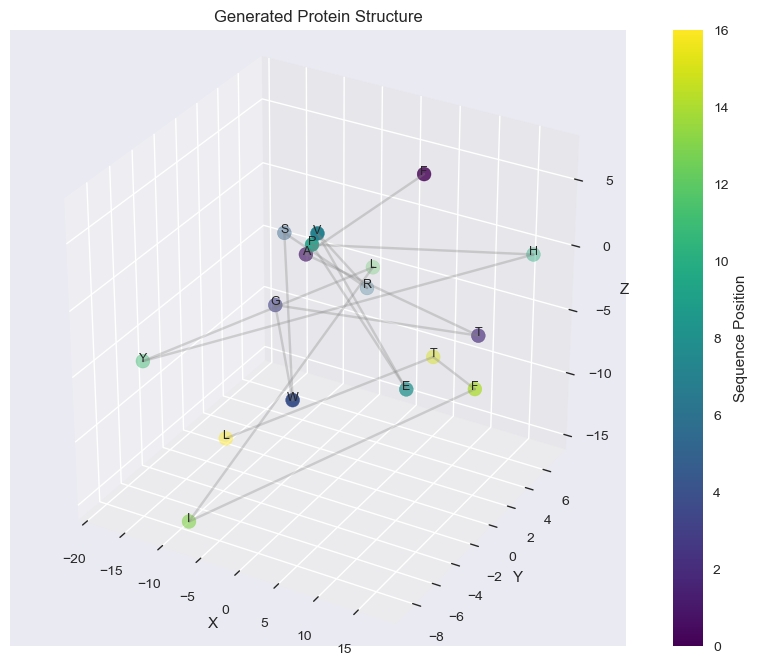

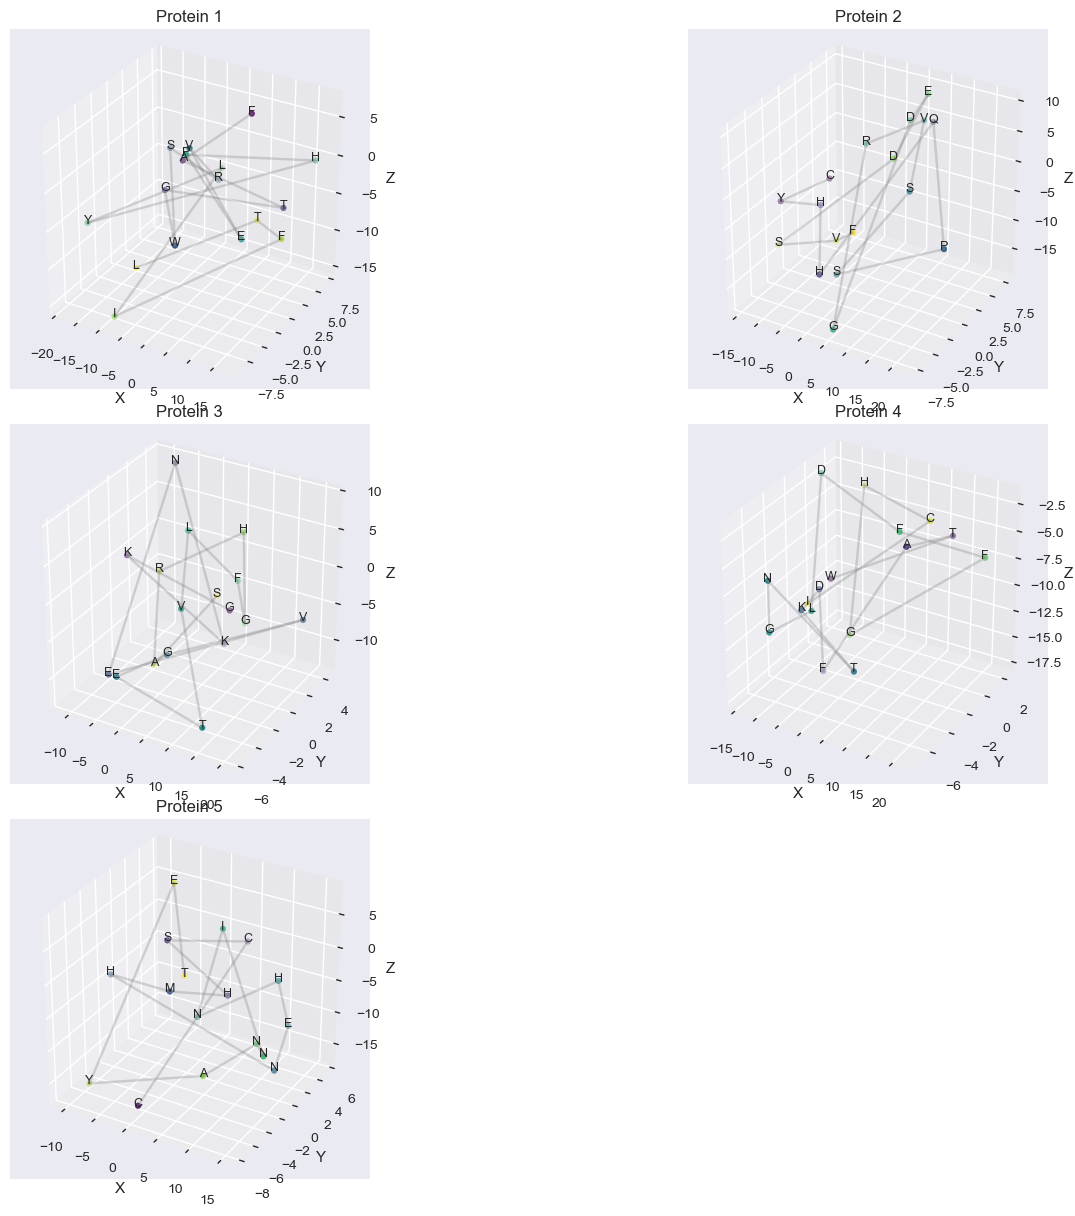

Protein Structure Analysis:
Number of residues: 17
Number of edges (prob > 0.5): 16
Average edge probability: 0.611
Spatial extent: 44.476

Position ranges:
X: [-18.377, 17.237]
Y: [-8.772, 7.175]
Z: [-14.610, 6.732]


In [31]:
# To visualize a single protein
fig, ax = visualize_protein_structure(generated_proteins[0], 
                                    title="Generated Protein Structure",
                                    edge_threshold=0.5)
plt.show()

# To visualize all proteins in a grid
fig = plot_protein_batch(generated_proteins, 
                        ncols=2,
                        edge_threshold=0.5,
                        node_size=17)
plt.show()

# To analyze a protein's structure
stats = analyze_protein_structure(generated_proteins[0])

INFO:__main__:
Generating protein 1/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 2/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 3/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 4/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 5/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 1/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generat

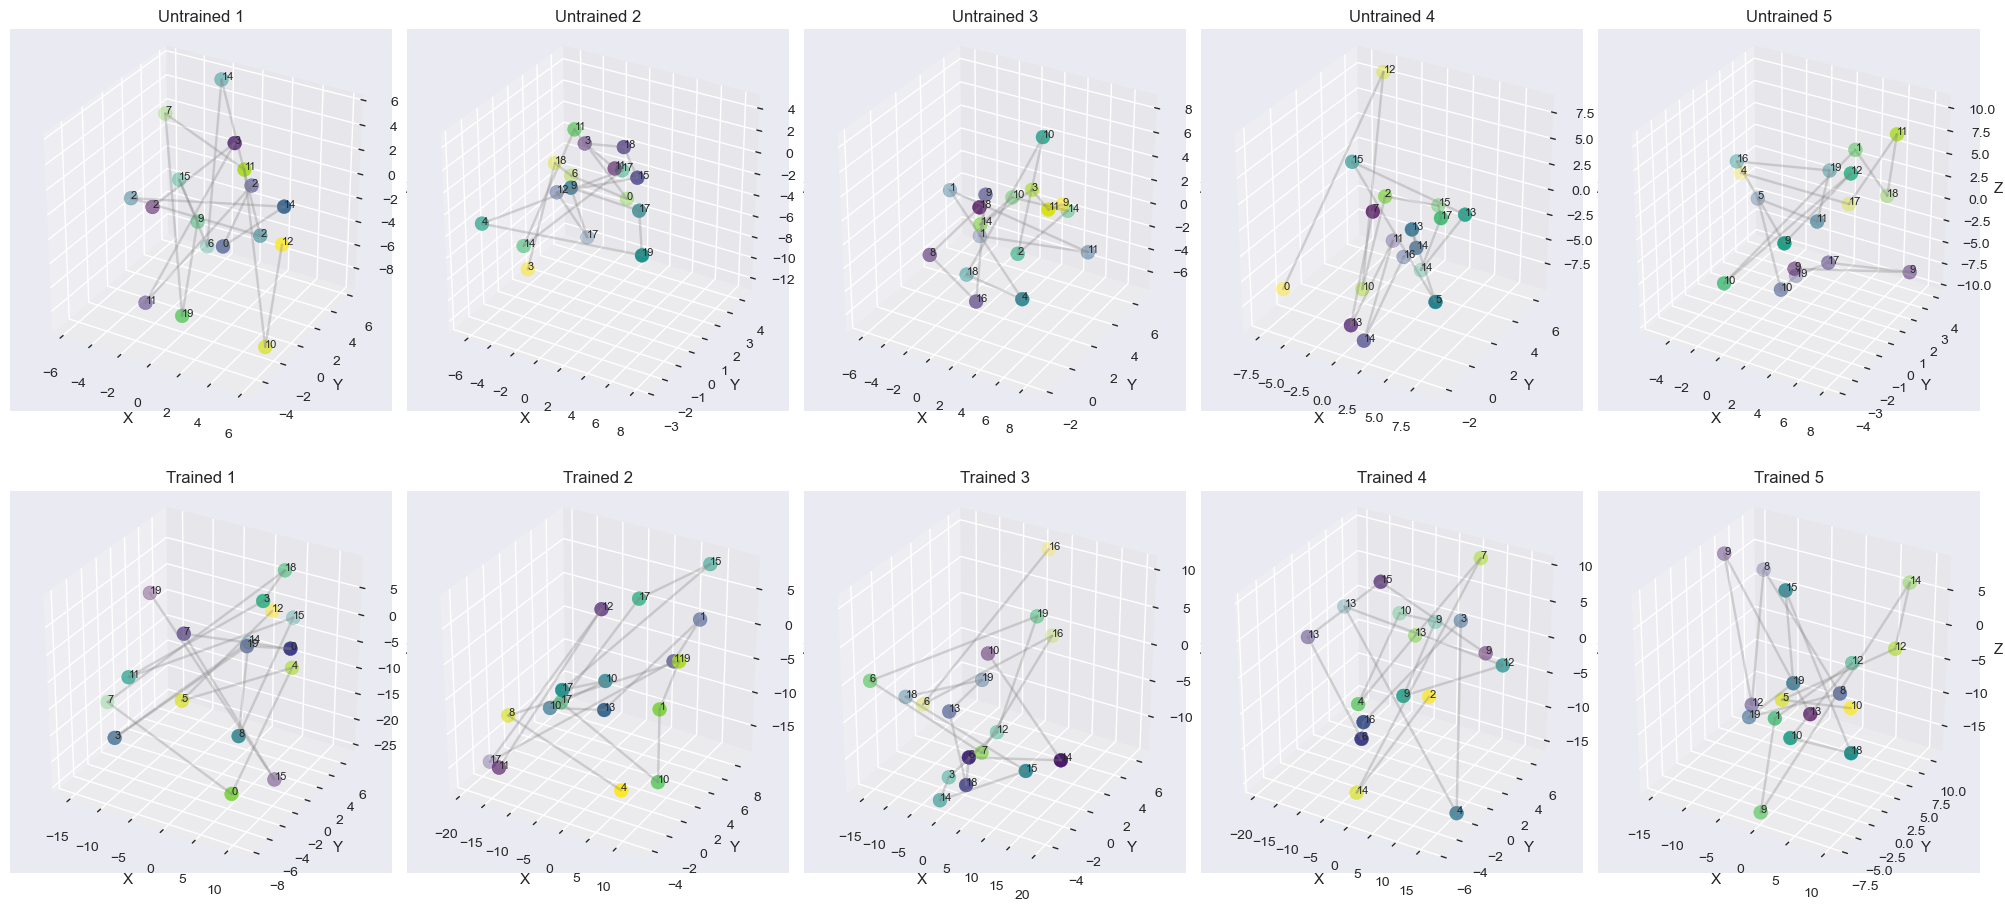

INFO:__main__:
Generating protein 1/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 2/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 3/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 4/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 5/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generating protein 1/5
INFO:__main__:Latent vector shape: torch.Size([17, 32])
INFO:__main__:Initial backbone edge index shape: torch.Size([2, 32])
INFO:__main__:
Generat

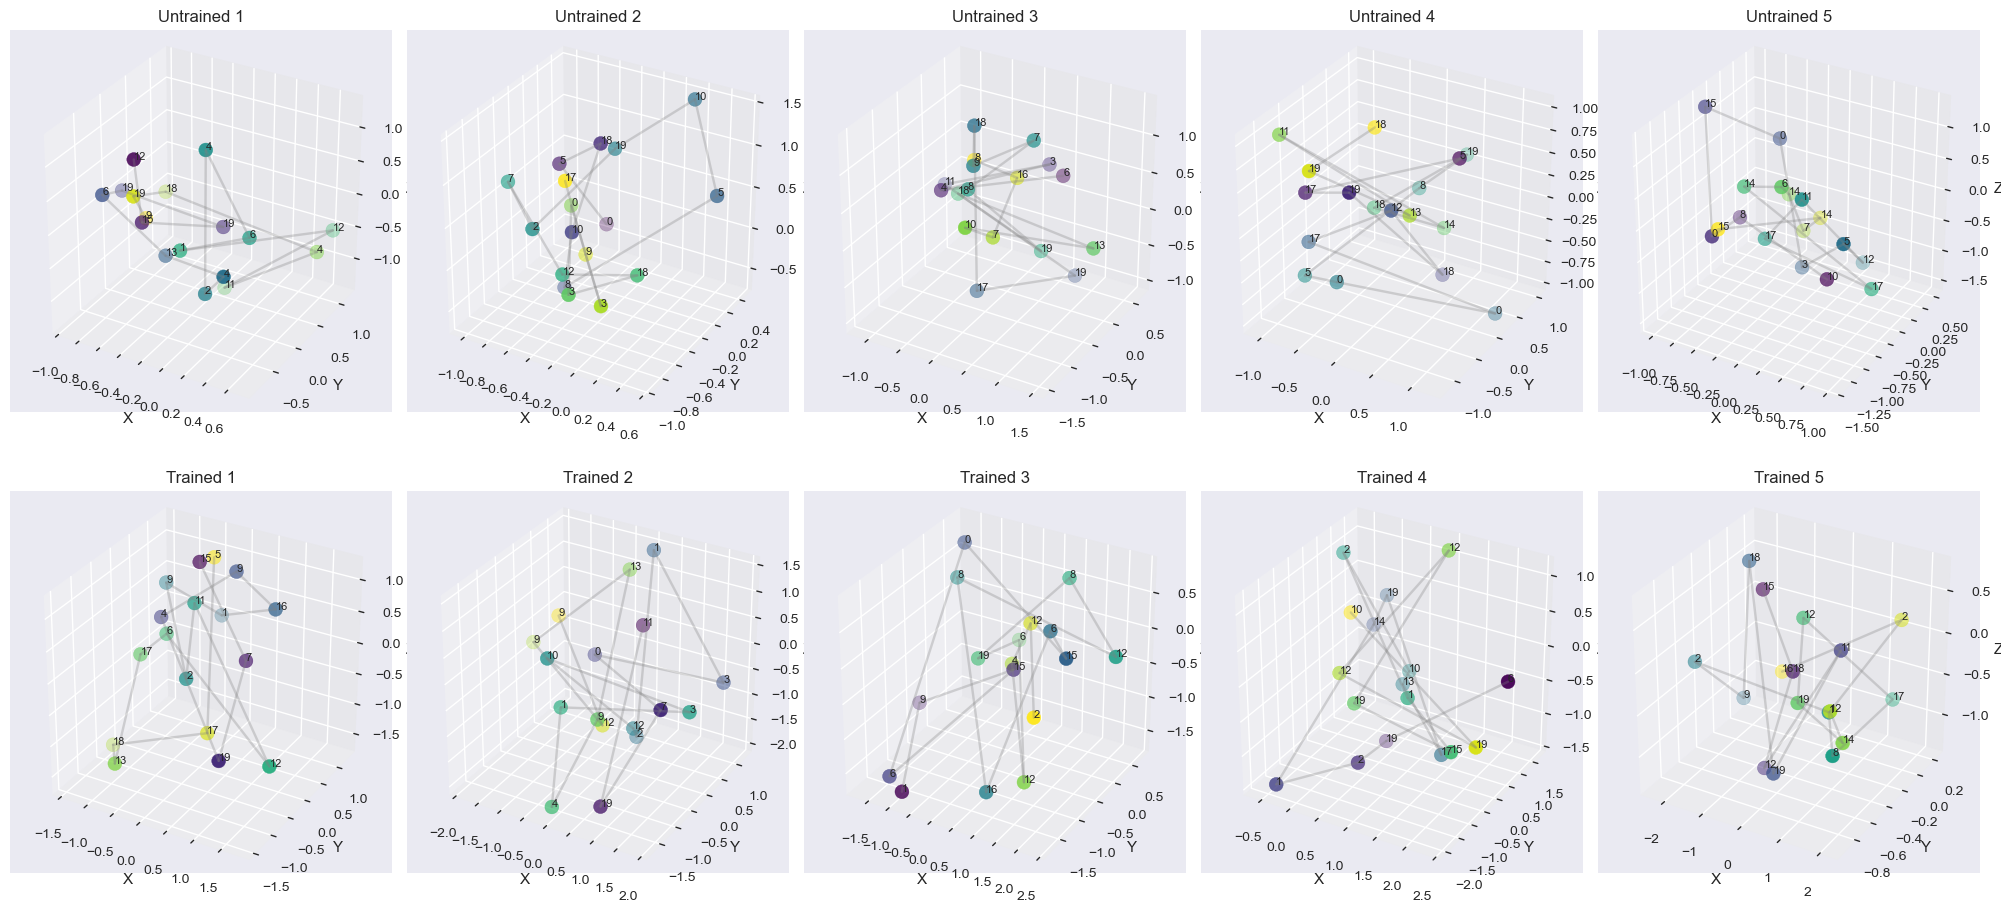

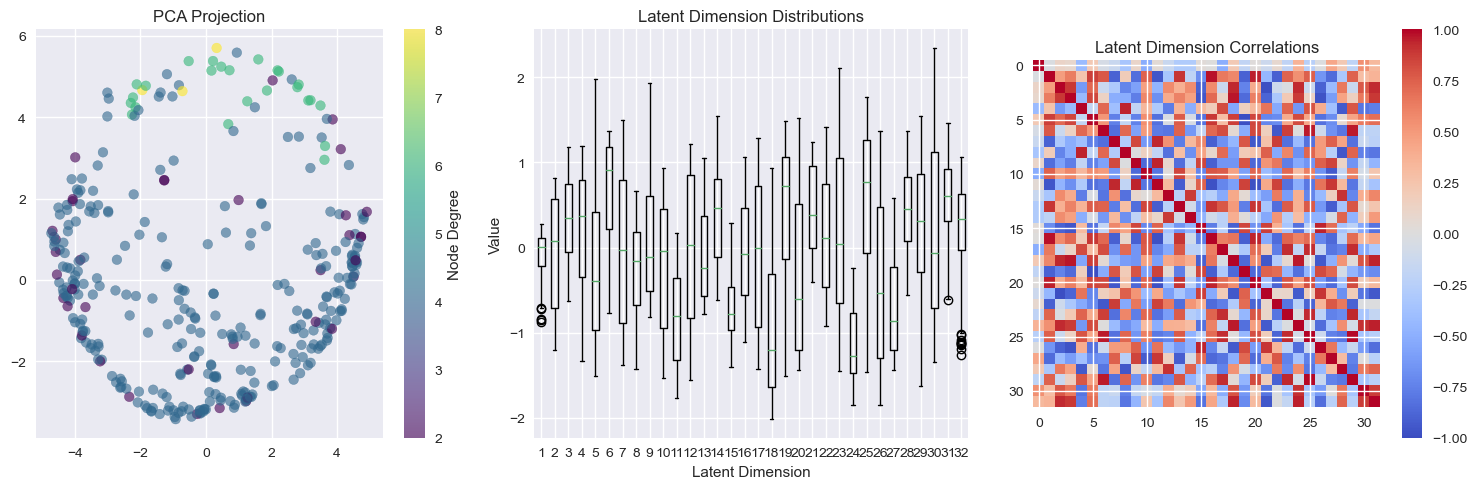

In [32]:
def compare_generated_proteins(model_untrained, model_trained, num_proteins=5, num_residues=100, device='cpu', normalizer=None):
    # Generate proteins with both models
    with torch.no_grad():
        proteins_untrained = generate_protein_structures(
            model_untrained,
            normalizer,
            num_proteins=num_proteins,
            num_residues=num_residues,
            device=device,
            min_prob_threshold=0.5
        )
        proteins_trained = generate_protein_structures(
            model_trained,
            normalizer,
            num_proteins=num_proteins,
            num_residues=num_residues,
            device=device,
            min_prob_threshold=0.5
        )

    # Create a figure with two rows: untrained and trained
    fig = plt.figure(figsize=(20, 10))

    # Plot untrained proteins
    for i, protein in enumerate(proteins_untrained):
        ax = fig.add_subplot(2, num_proteins, i + 1, projection='3d')
        plot_single_protein(protein, ax, f'Untrained {i+1}')

    # Plot trained proteins
    for i, protein in enumerate(proteins_trained):
        ax = fig.add_subplot(2, num_proteins, i + num_proteins + 1, projection='3d')
        plot_single_protein(protein, ax, f'Trained {i+1}')

    plt.tight_layout()
    return fig

# Usage:
compare_fig = compare_generated_proteins(
    untrained_model,
    model,
    num_proteins=5,
    num_residues=17,
    device=device,
    normalizer=normalizer  # Pass the normalizer
)
plt.show()

def plot_single_protein(protein, ax, title):
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    amino_acids = protein['amino_acids']

    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

    # Plot nodes
    scatter = ax.scatter(x, y, z, c=range(len(x)), cmap='viridis', s=100)

    # Add amino acid labels
    for i, aa in enumerate(amino_acids):
        ax.text(x[i], y[i], z[i], str(aa), fontsize=8)

    # Plot edges
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            if edge_probs[i, j] > 0.5:
                ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                        color='gray', alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1,1,1])

def analyze_latent_space(model, loader, device, perplexity=30):
    # Collect embeddings and metadata
    embeddings = []
    node_degrees = []
    amino_acids = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch)

            # Get node degrees
            degrees = torch.zeros(batch.x.size(0), device=device)
            unique_nodes, counts = torch.unique(batch.edge_index[0], return_counts=True)
            degrees[unique_nodes] = counts.float()

            embeddings.append(mu.cpu())
            node_degrees.append(degrees.cpu())
            amino_acids.append(batch.x.argmax(dim=1).cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    node_degrees = torch.cat(node_degrees, dim=0).numpy()
    amino_acids = torch.cat(amino_acids, dim=0).numpy()

    # Create visualization
    fig = plt.figure(figsize=(15, 5))

    # PCA plot
    ax1 = fig.add_subplot(131)
    pca = PCA(n_components=2)
    latent_2d_pca = pca.fit_transform(embeddings)
    scatter = ax1.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1],
                          c=node_degrees, cmap='viridis', alpha=0.6)
    ax1.set_title('PCA Projection')
    plt.colorbar(scatter, ax=ax1, label='Node Degree')

    # Distribution of latent dimensions
    ax2 = fig.add_subplot(132)
    ax2.boxplot([embeddings[:, i] for i in range(embeddings.shape[1])])
    ax2.set_title('Latent Dimension Distributions')
    ax2.set_xlabel('Latent Dimension')
    ax2.set_ylabel('Value')

    # Correlation matrix
    ax3 = fig.add_subplot(133)
    corr_matrix = np.corrcoef(embeddings.T)
    im = ax3.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax3.set_title('Latent Dimension Correlations')
    plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    return fig

# Usage example:
untrained_model = MolecularGVAE(node_features=train_graphs[0].x.size(1),
                                hidden_dim=64,
                                latent_dim=32,
                                num_neighbors=3).to(device)

# After training your model, you can call:
compare_fig = compare_generated_proteins(untrained_model, model,
                                         num_proteins=5,
                                         num_residues=17,
                                         device=device)
plt.show()

# Analyze latent space
latent_fig = analyze_latent_space(model, val_loader, device)
plt.show()

THIS IS A BETTER VISUALISATION:::INCLUDES LETTERS

In [30]:
# Define amino acid mapping
AA_LETTERS = {
    0: 'A', 1: 'R', 2: 'N', 3: 'D', 4: 'C',
    5: 'Q', 6: 'E', 7: 'G', 8: 'H', 9: 'I',
    10: 'L', 11: 'K', 12: 'M', 13: 'F', 14: 'P',
    15: 'S', 16: 'T', 17: 'W', 18: 'Y', 19: 'V'
}

def visualize_protein_structure(protein, title=None, figsize=(12, 8),
                                edge_threshold=0.5, show_edges=True,
                                alpha_edges=0.3, node_size=100):
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    amino_acids = protein['amino_acids']

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes (amino acids)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    scatter = ax.scatter(x, y, z,
                         c=range(len(x)),
                         cmap='viridis',
                         s=node_size)

    # Add amino acid letter labels
    for i, aa_num in enumerate(amino_acids):
        aa_letter = AA_LETTERS[aa_num]
        ax.text(x[i], y[i], z[i], aa_letter, fontsize=9, ha='center')

    # Plot edges if requested
    if show_edges:
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                if edge_probs[i, j] > edge_threshold:
                    ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                            color='gray', alpha=alpha_edges)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        plt.title(title)

    plt.colorbar(scatter, label='Sequence Position')
    ax.set_box_aspect([1,1,1])

    return fig, ax

def plot_protein_batch(proteins, ncols=2, figsize=(15, 12), **kwargs):
    nrows = (len(proteins) + ncols - 1) // ncols
    fig = plt.figure(figsize=figsize)

    for i, protein in enumerate(proteins):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        positions = protein['positions']
        edge_probs = protein['edge_probabilities']
        amino_acids = protein['amino_acids']
        x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

        scatter = ax.scatter(x, y, z,
                             c=range(len(x)),
                             cmap='viridis',
                             s=kwargs.get('node_size', 50))

        # Add amino acid letter labels
        for j, aa_num in enumerate(amino_acids):
            aa_letter = AA_LETTERS[aa_num]
            ax.text(x[j], y[j], z[j], aa_letter, fontsize=9, ha='center')

        if kwargs.get('show_edges', True):
            edge_threshold = kwargs.get('edge_threshold', 0.5)
            alpha_edges = kwargs.get('alpha_edges', 0.3)
            for j in range(len(positions)):
                for k in range(j+1, len(positions)):
                    if edge_probs[j, k] > edge_threshold:
                        ax.plot([x[j], x[k]], [y[j], y[k]], [z[j], z[k]],
                                color='gray', alpha=alpha_edges)

        ax.set_title(f'Protein {i+1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1,1,1])

    plt.tight_layout()
    return fig